# 0.0 Import Libraries
* Updated Normalisation Method for Fused MASKING
* LIDAR Feature + HSI Feature, Atrention , AutoEncoder

In [ ]:
pip install spectral mat73  einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
import os
import math

from einops import rearrange
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from scipy import io
import torch.utils.data
import scipy.io as sio
import mat73
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1.0 Upload Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! ls '/content/drive/MyDrive/A02_RemoteSensingData/UHS_2013_DFTC/'

In [ ]:
# # Define the path
path='/content/drive/MyDrive/A02_RemoteSensingData/UHS_2013_DFTC/'

In [ ]:
# 2.1 Loads Data
# Load hyperpsectral data
hsi_2013_data=sio.loadmat(path+'2013_IEEE_GRSS_DF_Contest_CASI_349_1905_144.mat')['ans']
print('hsi_2013_data shape:', hsi_2013_data.shape)

# Loader Lidar  data
import mat73
lidar_2013_data = sio.loadmat(path+'2013_IEEE_GRSS_DF_Contest_LiDAR.mat')['LiDAR_data']

print('Lidar_2013_data shape:', lidar_2013_data.shape)

#Load ground truth labels
gt_2013_data=sio.loadmat(path+'GRSS2013.mat')['name']
print('gt_2013_data.shape:', gt_2013_data.shape)

hsi_2013_data shape: (349, 1905, 144)
Lidar_2013_data shape: (349, 1905, 1)
gt_2013_data.shape: (349, 1905)


#1.1 Extract HSI and LiDAR smaple patches

In [ ]:
import numpy as np
import scipy.io as sio

# Function to extract a patch centered at (row, col)
def extract_patch(data, row, col, size, depth):
    half_size = size // 2
    return data[row-half_size:row+half_size+1, col-half_size:col+half_size+1, :depth]

# Function to randomly generate patch locations
def generate_patch_locations(num_samples, rows, cols, patch_size):
    half_size = patch_size // 2
    locations = []
    for _ in range(num_samples):
        row = np.random.randint(half_size, rows - half_size)
        col = np.random.randint(half_size, cols - half_size)
        locations.append((row, col))
    return locations

# Define parameters
num_samples = 20000
hsi_patch_size = 3 # 9x9 patch
hsi_depth = 144     # Assuming depth is 144 as per your data
lidar_patch_size = 3
lidar_depth = 1

# Assuming hsi_2013_data and lidar_2013_data are already loaded
rows, cols, _ = hsi_2013_data.shape

# Generate random patch locations
patch_locations = generate_patch_locations(num_samples, rows, cols, hsi_patch_size)

# Extract patches
hsi_patches = np.array([extract_patch(hsi_2013_data, row, col, hsi_patch_size, hsi_depth) for row, col in patch_locations])
lidar_patches = np.array([extract_patch(lidar_2013_data, row, col, lidar_patch_size, lidar_depth) for row, col in patch_locations])

print('HSI Patches shape:', hsi_patches.shape)
print('LiDAR Patches shape:', lidar_patches.shape)


HSI Patches shape: (20000, 3, 3, 144)
LiDAR Patches shape: (20000, 3, 3, 1)


In [ ]:
# Assuming lidar_2013_data is already loaded and has shape (rows, cols, 1)
# After extracting the LiDAR patches, repeat them across the depth dimension to match HSI's depth
# Extract LiDAR patches
lidar_patches_single_channel = np.array([
    extract_patch(lidar_2013_data, row, col, lidar_patch_size, lidar_depth)
    for row, col in patch_locations
])

# Repeat the single LiDAR channel to match the number of HSI channels
lidar_patches = np.repeat(lidar_patches_single_channel, hsi_depth, axis=-1)

print('LiDAR Patches shape after repeating channels:', lidar_patches.shape)



LiDAR Patches shape after repeating channels: (20000, 3, 3, 144)


##1.2 Normalisation

In [ ]:
def normalize_hsi_patches(hsi_patches):
    # Initialize an array to store the normalized patches
    normalized_patches = np.zeros_like(hsi_patches, dtype=np.float32)

    # Iterate over each band
    for band in range(hsi_patches.shape[-1]):
        band_data = hsi_patches[:, :, :, band]
        min_val = np.min(band_data)
        max_val = np.max(band_data)

        # Normalize this band
        normalized_patches[:, :, :, band] = (band_data - min_val) / (max_val - min_val) if max_val > min_val else band_data

    return normalized_patches

normalized_hsi_patches = normalize_hsi_patches(hsi_patches)
print('normalized_hsi_patches shape:',normalized_hsi_patches.shape)

normalized_hsi_patches shape: (20000, 3, 3, 144)


In [ ]:
def normalize_lidar_patches(lidar_patches):
    min_val = np.min(lidar_patches)
    max_val = np.max(lidar_patches)

    return (lidar_patches - min_val) / (max_val - min_val) if max_val > min_val else lidar_patches

normalized_lidar_patches = normalize_lidar_patches(lidar_patches)
print('normalized_lidar_patches.shape:',normalized_lidar_patches.shape)

normalized_lidar_patches.shape: (20000, 3, 3, 144)


#2.0 Model Building

### 2.1 Configuration

In [ ]:
# 2.1 Configuration
class Config:
    def __init__(self,in_channels,num_patches,kernel_size,patch_size,emb_size,heads,dim_head,output_dim, dropout,pos_emb_size,stride ):
        self.in_channels = in_channels
        self.num_patches = num_patches
        self.kernel_size = kernel_size
        self.patch_size = patch_size
        self.emb_size = emb_size
        self.heads = heads
        self.dim_head = dim_head
        #self.input_dim = input_dim
        self.output_dim=output_dim
        self.dropout = dropout
        self.pos_emb_size = pos_emb_size
        self.stride = stride


### 2.2 Patch Embedding

In [ ]:

class PatchEmbedding(nn.Module):
    def __init__(self, config):
        super().__init__()
            self.proj = nn.Conv2d(
            in_channels=config.in_channels,   # Number of spatial size w*h (e.g.,9*9)
            out_channels=config.emb_size,     # Number of output channels (embedding size)
            kernel_size=config.kernel_size,    # Size of the kernel (patch size)
            stride=config.stride,             # Stride for the convolution
        )
        # Positional embeddings
        self.pos_embedding = nn.Parameter(torch.zeros(1, config.num_patches + 1, config.emb_size))

    def forward(self, x):
        B, C, H, W = x.shape
        # Apply the convolution layer to get patch embeddings
        x = self.proj(x)
        # Flatten and transpose to get the correct shape
        x = x.flatten(2).transpose(1, 2)
        # Add position embeddings to the patch embeddings
        x = x + self.pos_embedding[:, :x.size(1)]
        return x



### 2.3 Attention Module

In [ ]:
import torch.nn as nn

class AttentionModule(nn.Module):
    def __init__(self, in_channels, emb_size, num_heads, dropout_rate, num_patches):
        super(AttentionModule, self).__init__()
        #self.device = device

        # Project input to emb_size
        self.input_projection = nn.Linear(emb_size, emb_size)

        # Normalization layers
        self.norm1 = nn.LayerNorm(emb_size)
        self.norm2 = nn.LayerNorm(emb_size)

        # Multi-head attention
        self.multihead_attn = nn.MultiheadAttention(embed_dim=emb_size, num_heads=num_heads, dropout=dropout_rate)

        # Linear layers followed by ELU activation
        self.linear1 = nn.Linear(emb_size, emb_size)
        self.elu1 = nn.ELU()
        self.linear2 = nn.Linear(emb_size, emb_size)
        self.elu2 = nn.ELU()
        self.linear3 = nn.Linear(emb_size, num_patches)
        self.elu3 = nn.ELU()

        # Final Linear layer, projecting back to the original channel size
        self.final_linear = nn.Linear(num_patches, in_channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Ensure input is on the correct device
        #x = x.to(self.device)

        # Apply input projection and normalization
        x = self.input_projection(x)
        x_norm = self.norm1(x)

        # Multi-head attention
        attn_output, _ = self.multihead_attn(x_norm, x_norm, x_norm)
        attn_output_norm = self.norm2(attn_output + x)

        # Sequential linear layers and activations
        x = self.elu1(self.linear1(attn_output_norm))
        x = self.elu2(self.linear2(x))
        x = self.elu3(self.linear3(x))

        # Final linear transformation and sigmoid activation
        x = self.sigmoid(self.final_linear(x))
        return x


### 2.4 CNNAutoEncoder-AVGPooling

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNAutoEncoder(nn.Module):
    def __init__(self, config, ):
        super(CNNAutoEncoder, self).__init__()

        self.patch_size = config.patch_size
       # self.device = device  # Storing the device information

        # Encoder
        self.conv1 = nn.Conv2d(in_channels=config.in_channels, out_channels=config.emb_size,
                               kernel_size=config.kernel_size, stride=config.stride, padding=1)
        self.elu1 = nn.ELU()
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=config.emb_size, out_channels=config.output_dim,
                               kernel_size=config.kernel_size, stride=config.stride, padding=1)
        self.elu2 = nn.ELU()
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        # Decoder
        self.deconv1 = nn.ConvTranspose2d(in_channels=config.output_dim, out_channels=config.emb_size,
                                          kernel_size=config.kernel_size, stride=2, padding=1, output_padding=1)
        self.elu3 = nn.ELU()

        self.deconv2 = nn.ConvTranspose2d(in_channels=config.emb_size, out_channels=config.in_channels,
                                          kernel_size=config.kernel_size, stride=2, padding=1, output_padding=1)
        self.elu4 = nn.ELU()

    def forward(self, x):
        # Encoding
        x = self.elu1(self.conv1(x))
        x = self.pool1(x)

        x = self.elu2(self.conv2(x))
        x = self.pool2(x)

        # Decoding
        x = self.elu3(self.deconv1(x))
        x = self.elu4(self.deconv2(x))

        # Resize to the original size to match the input dimensions
        x = F.interpolate(x, size=(self.patch_size, self.patch_size), mode='nearest')

        return x


### 2.5 HSIAttentionSubmodel

In [ ]:
import torch.nn as nn

class HSIAttentionSubmodel(nn.Module):
    def __init__(self, hsi_config):
        super(HSIAttentionSubmodel, self).__init__()
        #self.device = device  # Store the device to use

        # Initialize PatchEmbedding and AttentionModule with device handling
        self.patch_embedding = PatchEmbedding(hsi_config)
        self.attention_module = AttentionModule(
            in_channels=hsi_config.in_channels,
            emb_size=hsi_config.emb_size,
            num_heads=hsi_config.heads,
            dropout_rate=hsi_config.dropout,
            num_patches=hsi_config.num_patches,
        )

    def forward(self, x):
       # x = x.to(self.device)  # Ensure input is on the correct device

        # Process through patch embedding and attention module
        x = self.patch_embedding(x)
        x = self.attention_module(x)
        return x



### 2.6 LiDARAttentionSubmodel

In [ ]:
import torch.nn as nn

class LiDARAttentionSubmodel(nn.Module):
    def __init__(self, lidar_config):
        super(LiDARAttentionSubmodel, self).__init__()
       # self.device = device  # Store the device to use

        # Initialize PatchEmbedding and AttentionModule with device handling
        self.patch_embedding = PatchEmbedding(lidar_config)
        self.attention_module = AttentionModule(
            in_channels=lidar_config.in_channels,
            emb_size=lidar_config.emb_size,
            num_heads=lidar_config.heads,
            dropout_rate=lidar_config.dropout,
            num_patches=lidar_config.num_patches,
        )

    def forward(self, x):
       # x = x.to(self.device)  # Ensure input is on the correct device

        # Process through patch embedding and attention module
        x = self.patch_embedding(x)
        x = self.attention_module(x)
        return x


### 2.7 Integrated Model

In [ ]:
class IntegratedModel(nn.Module):
    def __init__(self, hsi_config, lidar_config):
        super(IntegratedModel, self).__init__()
       # self.device = device

        # Pass the device to each submodel
        self.hsi_attention_submodel = HSIAttentionSubmodel(hsi_config)
        self.lidar_attention_submodel = LiDARAttentionSubmodel(lidar_config)
        self.autoencoder = CNNAutoEncoder(hsi_config)  # Make sure CNNAutoEncoder also handles device correctly
        # Make sure to initialize positional embeddings here
        #self.pos_embedding = torch.rand(1, max_length, embedding_dim).to(device)  # Example initialization

    def forward(self, hsi_sample, lidar_sample):
        # Process through attention submodels
        hsi_attention_output = self.hsi_attention_submodel(hsi_sample)
        lidar_attention_output = self.lidar_attention_submodel(lidar_sample)

        #Add Lidar to HSI sample To assure the autoencoder input to have lidar also
        hsi_sample=hsi_sample+lidar_sample # Input and output 144 >145  # Temporarily removed

        # Flatten and transpose the HSI and LiDAR sample to match the attention mask shape
        hsi_sample_flattened = hsi_sample.view(hsi_sample.shape[0], hsi_sample.shape[1], -1)

        # Fuse the HSI and LiDAR attention outputs
        fused_attention_output = hsi_attention_output + lidar_attention_output
        fused_attention_output_transposed = fused_attention_output.transpose(1, 2)

        # Element-wise multiplication
        elementwise_result = hsi_sample_flattened * fused_attention_output_transposed

        num_samples, num_channels, height, width = hsi_sample.shape
        # This needs to be consistent with the actual size of elementwise_result
        new_height, new_width = height, width  # adjust as needed

        # Reshape for input into the autoencoder
        autoencoder_input = elementwise_result.view(num_samples, num_channels, new_height, new_width)  # Hsi

        # Access one channe from lidar and concatenare with autoncoder_input, 145 channek
        # Select one LiDAR channel to concatenate (assuming channel index 0 for example)
        #lidar_channel = lidar_sample[:, 0, :, :].unsqueeze(1)  # Add a channel dimension
        # Concatenate along the channel dimension
        #autoencoder_input = torch.cat((autoencoder_input, lidar_channel), dim=1)

        # Pass through the autoencoder
        autoencoder_output = self.autoencoder(autoencoder_input)  #output 145

        return fused_attention_output, autoencoder_output


# 3.0 LossFuntion

In [ ]:
class CustomLoss(nn.Module):
    def __init__(self, lambda1):
        super(CustomLoss, self).__init__()
        self.lambda1 = lambda1

    def forward(self, autoencoder_output, hsi_sample, lidar_sample, fused_mask):


        # Concatenate along the channel dimension
        hsi_sample_combined=hsi_sample+lidar_sample

        # Calculate the reconstruction loss between the autoencoder's output and the target input
        recon_loss = F.mse_loss(autoencoder_output, hsi_sample_combined)

        #Calculate the sparsity loss based on the fused_mask
        sparsity_loss = torch.sum(torch.sqrt(torch.sum(fused_mask ** 2, dim=2))) * self.lambda1

       # Combine the losses
        total_loss = 0.5 * recon_loss + sparsity_loss
        return total_loss



### 3.5 configuration and Integrated Model

In [ ]:
# Hsi configuration
hsi_config = Config(
    in_channels=144,  # Each sample covers 144 bands
    num_patches=144,  # Channeles to patch number
    kernel_size=(1,1),
    patch_size=3,  # Adjusted to match new patch size (5*5, 144/24=6)
    emb_size=256,  # Embedding size, this can be changed
    heads=8,  # Number of attention heads, this can be changed
    dim_head=64,  # Dimension of each attention head, this can be changed
    #input_dim=144,  # Dimension of the MLP layer, this can be changed
    output_dim=256,
    dropout=0.2,  # Dropout rate, this can be changed
    pos_emb_size=256,  # Position embedding size, this can be changed
    stride=1  # Stride for the convolution, this can be changed
)


# Lidara configuration
lidar_config = Config(
    in_channels=144,  # lidar group has 1 channels
    num_patches=144,  # 1 band for Lidar
    kernel_size=(1,1),  # Adjusted to match new patch size
    patch_size=3, # Adjusted to match new patch size
    emb_size=256,  # Embedding size, this can be changed
    heads=8,  # Number of attention heads, this can be changed
    dim_head=64,  # Dimension of each attention head, this can be changed
    #input_dim=1,  # Dimension of the MLP layer, this can be changed
    output_dim=256,
    dropout=0.2,  # Dropout rate, this can be changed
    pos_emb_size=256,  # Position embedding size, this can be changed
    stride=1 # Stride for the convolution, this can be changed
)
# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 4.0 Training Data Preparation

In [ ]:

# Select one sample patch
sample_hsi_patch = normalized_hsi_patches # First patch for demonstration
sample_lidar_patch = normalized_lidar_patches

# Convert patches to float32
sample_hsi_patch = sample_hsi_patch.astype(np.float32)
sample_lidar_patch = sample_lidar_patch.astype(np.float32)

print('sample_hsi_patch shape:', sample_hsi_patch.shape)
print('sample_lidar_patch shape:', sample_lidar_patch.shape)

# Reshape patches to match the input shape expected by the model
# (Batch size, Channels, Height, Width)
sample_hsi_patch = np.transpose(sample_hsi_patch, (0, 3, 1, 2))  # Rearrange dimensions to (5000, 144, 9, 9)
sample_lidar_patch = np.transpose(sample_lidar_patch, (0, 3, 1, 2))  # Rearrange dimensions to (5000, 144, 9, 9)
print('sample_hsi_patch_transpose shape:', sample_hsi_patch.shape)
print('sample_lidar_patch_transpose shape:', sample_lidar_patch.shape)

# Convert numpy arrays to tensors and immediately transfer them to the device
sample_hsi_patch_tensor = torch.tensor(sample_hsi_patch)
sample_lidar_patch_tensor = torch.tensor(sample_lidar_patch)
print('sample_hsi_patch_tensorshape:', sample_hsi_patch_tensor.shape)
print('sample_lidar_patch_tensoshape:', sample_lidar_patch_tensor.shape)


sample_hsi_patch shape: (20000, 3, 3, 144)
sample_lidar_patch shape: (20000, 3, 3, 144)
sample_hsi_patch_transpose shape: (20000, 144, 3, 3)
sample_lidar_patch_transpose shape: (20000, 144, 3, 3)
sample_hsi_patch_tensorshape: torch.Size([20000, 144, 3, 3])
sample_lidar_patch_tensoshape: torch.Size([20000, 144, 3, 3])


In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# Select one sample patch
sample_hsi_patch = normalized_hsi_patches # First patch for demonstration
sample_lidar_patch = normalized_lidar_patches
# sample_hsi_patch = hsi_patches # First patch for demonstration
# sample_lidar_patch = lidar_patches

# Convert patches to float32
sample_hsi_patch = sample_hsi_patch.astype(np.float32)
sample_lidar_patch = sample_lidar_patch.astype(np.float32)
print('sample_hsi_patch shape:', sample_hsi_patch.shape)
print('sample_lidar_patch shape:', sample_lidar_patch.shape)


# Convert patches to PyTorch tensors
sample_hsi_patch_tensor = torch.tensor(sample_hsi_patch)
sample_lidar_patch_tensor = torch.tensor(sample_lidar_patch)
print('sample_hsi_patch_tensorshape:', sample_hsi_patch_tensor.shape)
print('sample_lidar_patch_tensoshape:', sample_lidar_patch_tensor.shape)

# Now reshape HSI data such that spatial dimensions (9x9) are flattened and treated as channels
hsi_batch_flat = torch.from_numpy(sample_hsi_patch.astype(np.float32).reshape(sample_hsi_patch_tensor.shape[0], hsi_config.in_channels, hsi_config.patch_size*hsi_config.patch_size, 1)).to(device)
lidar_batch_flat = torch.from_numpy(sample_lidar_patch.astype(np.float32).reshape(sample_lidar_patch_tensor.shape[0], lidar_config.in_channels, lidar_config.patch_size*lidar_config.patch_size, 1)).to(device)
print('hsi_batch_flat shape:', hsi_batch_flat.shape)
print('lidar_batch_flat shape:', lidar_batch_flat.shape)

hsi_batch_flat = hsi_batch_flat.to(device)  # Move the tensor to GPU
lidar_batch_flat = lidar_batch_flat.to(device)  # Move the tensor to GPU

# Calculate the number of samples for training and testing
num_train_samples = int(0.9 * num_samples)
num_test_samples = num_samples - num_train_samples

# First, split into initial train and test sets
hsi_initial_train, hsi_test, lidar_initial_train, lidar_test = train_test_split(
    sample_hsi_patch_tensor, sample_lidar_patch_tensor, test_size=num_test_samples, random_state=42)

# Further split the initial training set into actual training and validation sets
hsi_train, hsi_val, lidar_train, lidar_val = train_test_split(
    hsi_initial_train, lidar_initial_train, test_size=0.20, random_state=42)  # 0.25 x 0.8 = 0.2 of the original dataset

print('hsi_train shape:', hsi_train.shape)
print('hsi_val shape:', hsi_val.shape)

# Reshape and transpose the training, validation, and testing sets
hsi_train = hsi_train.permute(0, 3, 1, 2)  # Reshape to [3000, 144, 9, 9]
hsi_val = hsi_val.permute(0, 3, 1, 2)      # Reshape to [1000, 144, 9, 9]
hsi_test = hsi_test.permute(0, 3, 1, 2)    # Apply similar transformation to test set
print('hsi_train shape after permuted:', hsi_train.shape)
print('hsi_val shape after permuted:', hsi_val.shape)
print('hsi_test shape after permuted:', hsi_test.shape)

lidar_train = lidar_train.permute(0, 3, 1, 2)  # Apply similar transformation
lidar_val = lidar_val.permute(0, 3, 1, 2)      # Apply similar transformation
lidar_test = lidar_test.permute(0, 3, 1, 2)    # Apply similar transformation
print('lidar_train shape after permuted:', lidar_train.shape)
print('lidar_val shape after permuted:', lidar_val.shape)
print('lidar_test shape after permuted:', lidar_test.shape)

# Create TensorDatasets for training, validation, and testing sets
hsi_train_dataset = TensorDataset(hsi_train)
hsi_val_dataset = TensorDataset(hsi_val)
hsi_test_dataset = TensorDataset(hsi_test)

lidar_train_dataset = TensorDataset(lidar_train)
lidar_val_dataset = TensorDataset(lidar_val)
lidar_test_dataset = TensorDataset(lidar_test)

# Create DataLoaders for each set
hsi_train_dataloader = DataLoader(hsi_train_dataset, batch_size=32, shuffle=True)
hsi_val_dataloader = DataLoader(hsi_val_dataset, batch_size=32, shuffle=False)
hsi_test_dataloader = DataLoader(hsi_test_dataset, batch_size=32, shuffle=False)

lidar_train_dataloader = DataLoader(lidar_train_dataset, batch_size=32, shuffle=True)
lidar_val_dataloader = DataLoader(lidar_val_dataset, batch_size=32, shuffle=False)
lidar_test_dataloader = DataLoader(lidar_test_dataset, batch_size=32, shuffle=False)

# Now we have separate dataloaders for train, val, and test datasets

sample_hsi_patch shape: (20000, 3, 3, 144)
sample_lidar_patch shape: (20000, 3, 3, 144)
sample_hsi_patch_tensorshape: torch.Size([20000, 3, 3, 144])
sample_lidar_patch_tensoshape: torch.Size([20000, 3, 3, 144])
hsi_batch_flat shape: torch.Size([20000, 144, 9, 1])
lidar_batch_flat shape: torch.Size([20000, 144, 9, 1])
hsi_train shape: torch.Size([14400, 3, 3, 144])
hsi_val shape: torch.Size([3600, 3, 3, 144])
hsi_train shape after permuted: torch.Size([14400, 144, 3, 3])
hsi_val shape after permuted: torch.Size([3600, 144, 3, 3])
hsi_test shape after permuted: torch.Size([2000, 144, 3, 3])
lidar_train shape after permuted: torch.Size([14400, 144, 3, 3])
lidar_val shape after permuted: torch.Size([3600, 144, 3, 3])
lidar_test shape after permuted: torch.Size([2000, 144, 3, 3])


# 5.0 Training Model

In [ ]:
# Initialize the model
model = IntegratedModel(hsi_config, lidar_config)

# Hyperparameters
num_epochs = 30
learning_rate = 0.0001
batch_size = 32
lambda1_value = 0.5 # Custom loss lambda value

# Initialize the custom loss function
# Instantiate CustomLoss with the submodels and lambda value
custom_loss_function = CustomLoss(lambda1_value)
criterion = CustomLoss(lambda1_value)

# Optimizer
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # optimizer 1
optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)  # optimizer 2
#optimizer=torch.optim.RMSprop(model.parameters(), lr=learning_rate) #optimizer 3
#optimizer=torch.optim.AdamW(model.parameters(), lr=learning_rate) #optimizer 4

def train_model(model, criterion, optimizer, num_epochs, hsi_train_dataloader, lidar_train_dataloader, device, early_stopping_patience):
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for (hsi_patches,), (lidar_patches,) in zip(hsi_train_dataloader, lidar_train_dataloader):
            hsi_patches, lidar_patches = hsi_patches, lidar_patches

            optimizer.zero_grad()
           # fused_attention_output, autoencoder_input, autoencoder_output = model(hsi_patches, lidar_patches)
            # Perform forward pass
            fused_attention_output,  autoencoder_output = model(hsi_patches, lidar_patches)

            loss = custom_loss_function(autoencoder_output, hsi_patches, lidar_patches, fused_attention_output)
            #loss = criterion(autoencoder_output, hsi_patches)  # Adjust the loss function as needed
            train_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        train_loss /= len(hsi_train_dataloader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for (hsi_patches,), (lidar_patches,) in zip(hsi_val_dataloader, lidar_val_dataloader):
                hsi_patches, lidar_patches = hsi_patches.to(device), lidar_patches.to(device)
                fused_attention_output,  autoencoder_output = model(hsi_patches, lidar_patches)
                loss = custom_loss_function(autoencoder_output, hsi_patches, lidar_patches, fused_attention_output)
                val_loss += loss.item()

        val_loss /= len(hsi_val_dataloader)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == early_stopping_patience:
                print("Early stopping triggered.")
                break

# Example usage
early_stopping_patience = 10
train_model(model, custom_loss_function, optimizer, num_epochs, hsi_train_dataloader, lidar_train_dataloader, device, early_stopping_patience)

Epoch [1/30], Train Loss: 1666.9031, Val Loss: 1588.4380
Epoch [2/30], Train Loss: 1501.8365, Val Loss: 1384.6672
Epoch [3/30], Train Loss: 1249.5630, Val Loss: 1084.9724
Epoch [4/30], Train Loss: 909.9157, Val Loss: 716.4207
Epoch [5/30], Train Loss: 536.9001, Val Loss: 357.3492
Epoch [6/30], Train Loss: 220.8053, Val Loss: 106.4811
Epoch [7/30], Train Loss: 51.7332, Val Loss: 16.4216
Epoch [8/30], Train Loss: 6.3690, Val Loss: 1.2395
Epoch [9/30], Train Loss: 0.4088, Val Loss: 0.0922
Epoch [10/30], Train Loss: 0.0692, Val Loss: 0.0579
Epoch [11/30], Train Loss: 0.0530, Val Loss: 0.0507
Epoch [12/30], Train Loss: 0.0481, Val Loss: 0.0475
Epoch [13/30], Train Loss: 0.0456, Val Loss: 0.0457
Epoch [14/30], Train Loss: 0.0440, Val Loss: 0.0445
Epoch [15/30], Train Loss: 0.0430, Val Loss: 0.0436
Epoch [16/30], Train Loss: 0.0422, Val Loss: 0.0429
Epoch [17/30], Train Loss: 0.0415, Val Loss: 0.0423
Epoch [18/30], Train Loss: 0.0410, Val Loss: 0.0418
Epoch [19/30], Train Loss: 0.0405, Val Lo

In [ ]:
path='/content/drive/MyDrive/A02_RemoteSensingData/UHS_2013_DFTC/'
def save_model(model, optimizer, path):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, path)

# Example usage:
model_path = path+'Autoencodermodel_uh2013_sgdp3nfuseddata_20Ksample.pth'  # Adjust path as needed
save_model(model, optimizer, model_path)


In [ ]:
import torch
import torch.nn as nn
# Assuming IntegratedModel, HSIAttentionSubmodel, LiDARAttentionSubmodel, CNNAutoEncoder are defined
# Create an instance of your model
model = IntegratedModel(hsi_config, lidar_config)

# Define the path where your model is saved
model_path = path+'Autoencodermodel_uh2013_sgdp3nfuseddata_20Ksample.pth' # Update the path accordingly # test on 11/05/2024

# Load the state dictionary
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])

# Optionally, if you want to evaluate the model
model.eval()

# Print the parameters
for name, param in model.named_parameters():
    print(name, param.shape)

# Print the full state dictionary
print("Full state dict:")
print(model.state_dict())


hsi_attention_submodel.patch_embedding.pos_embedding torch.Size([1, 145, 256])
hsi_attention_submodel.patch_embedding.proj.weight torch.Size([256, 144, 1, 1])
hsi_attention_submodel.patch_embedding.proj.bias torch.Size([256])
hsi_attention_submodel.attention_module.input_projection.weight torch.Size([256, 256])
hsi_attention_submodel.attention_module.input_projection.bias torch.Size([256])
hsi_attention_submodel.attention_module.norm1.weight torch.Size([256])
hsi_attention_submodel.attention_module.norm1.bias torch.Size([256])
hsi_attention_submodel.attention_module.norm2.weight torch.Size([256])
hsi_attention_submodel.attention_module.norm2.bias torch.Size([256])
hsi_attention_submodel.attention_module.multihead_attn.in_proj_weight torch.Size([768, 256])
hsi_attention_submodel.attention_module.multihead_attn.in_proj_bias torch.Size([768])
hsi_attention_submodel.attention_module.multihead_attn.out_proj.weight torch.Size([256, 256])
hsi_attention_submodel.attention_module.multihead_attn

In [ ]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


Model's state_dict:
hsi_attention_submodel.patch_embedding.pos_embedding 	 torch.Size([1, 145, 256])
hsi_attention_submodel.patch_embedding.proj.weight 	 torch.Size([256, 144, 1, 1])
hsi_attention_submodel.patch_embedding.proj.bias 	 torch.Size([256])
hsi_attention_submodel.attention_module.input_projection.weight 	 torch.Size([256, 256])
hsi_attention_submodel.attention_module.input_projection.bias 	 torch.Size([256])
hsi_attention_submodel.attention_module.norm1.weight 	 torch.Size([256])
hsi_attention_submodel.attention_module.norm1.bias 	 torch.Size([256])
hsi_attention_submodel.attention_module.norm2.weight 	 torch.Size([256])
hsi_attention_submodel.attention_module.norm2.bias 	 torch.Size([256])
hsi_attention_submodel.attention_module.multihead_attn.in_proj_weight 	 torch.Size([768, 256])
hsi_attention_submodel.attention_module.multihead_attn.in_proj_bias 	 torch.Size([768])
hsi_attention_submodel.attention_module.multihead_attn.out_proj.weight 	 torch.Size([256, 256])
hsi_attent

# 6. Band Selection based on Applied Trained Model and Clustering

In [ ]:
# Create an instance of your model
model = IntegratedModel(hsi_config, lidar_config)

# Define the path where your model is saved
model_path = path+'Autoencodermodel_uh2013_sgdp3nfuseddata_20Ksample.pth' # Update the path accordingly

# Load the state dictionary
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])

# Optionally, if you want to evaluate the model
model.eval()

# List to store fused masks
all_fused_masks = []  # all_fused_attention_masks

# Process each pair of DataLoaders (HSI and LiDAR for train, val, test)
dataloaders = zip([hsi_train_dataloader, hsi_val_dataloader, hsi_test_dataloader],
                  [lidar_train_dataloader, lidar_val_dataloader, lidar_test_dataloader])

for hsi_loader, lidar_loader in dataloaders:
    with torch.no_grad():
        for hsi_patches, lidar_patches in zip(hsi_loader, lidar_loader):
            hsi_patches = hsi_patches[0].to(device)  # Unpack and move to device
            lidar_patches = lidar_patches[0].to(device)  # Unpack and move to device
            fused_mask,_ = model(hsi_patches, lidar_patches)
            all_fused_masks.append(fused_mask.cpu().numpy())

# Concatenate all fused masks
all_fused_masks = np.concatenate(all_fused_masks, axis=0)  # all_fused_attention_masks
print('all_fused_masks.shape:', all_fused_masks.shape)


all_fused_masks.shape: (20000, 9, 144)


In [ ]:
#6.0 Band Selection
import numpy as np

# Re-initializing the dummy data for demonstration as the state was reset
all_fused_masks = all_fused_masks
print('all_fused_masks shape:',all_fused_masks.shape)

# Compute the mean attention value across all samples and spatial locations for each band
# This will result in a vector A of length 144, where each Ai is the aggregated attention score for the i-th band
A = all_fused_masks.mean(axis=(0, 1))

# Normalize the aggregated attention scores to ensure they are on a comparable scale
A_norm = (A - A.min()) / (A.max() - A.min())

A_norm  # This is the normalized attention for each band
print('A_norm shape:', A_norm.shape)


all_fused_masks shape: (20000, 9, 144)
A_norm shape: (144,)


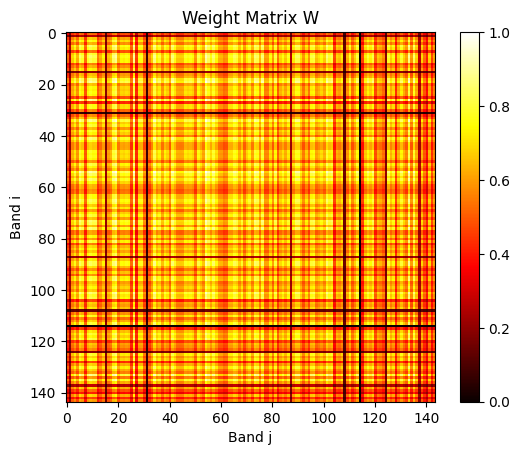

Attention matrix shape: (144, 144)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Sample normalized attention scores for each band
attention_scores = A_norm  # Normalize to sum to 1

# Calculate Weight Matrix W
num_bands = attention_scores.shape[0]
#W = np.zeros((num_bands, num_bands))
attention_distance_matrix = np.outer(A_norm, A_norm)
W = np.outer(A_norm, A_norm)

for i in range(num_bands):
    for j in range(num_bands):
        W[i, j] = attention_scores[i] *  attention_scores[j]
        #W[i, j] = (1 - attention_scores[i]) * (1 - attention_scores[j])

# Plot the Weight Matrix
plt.imshow(W, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Weight Matrix W')
plt.xlabel('Band j')
plt.ylabel('Band i')
plt.show()

print('Attention matrix shape:', W.shape)

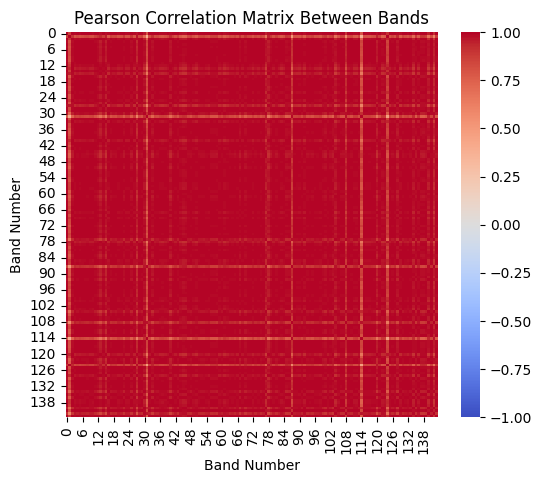

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'all_fused_masks' is available with shape (20000, 81, 144)
# Reshape to (20000*81, 144) for correlation computation
band_data = all_fused_masks.reshape(-1, all_fused_masks.shape[-1])

# Compute the Pearson Correlation Matrix across bands
correlation_matrix = np.corrcoef(band_data, rowvar=False)

# Plot the correlation matrix using seaborn's heatmap function
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Pearson Correlation Matrix Between Bands')
plt.xlabel('Band Number')
plt.ylabel('Band Number')
plt.show()


In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans
import numpy as np

# Assuming 'correlation_matrix' and 'A_norm' are defined earlier in your code
def calculate_combined_distance(A_norm, correlation_matrix, alpha=0.8, beta=0.2):
    # Using A_norm directly as it represents high attention
    attention_distance_matrix = np.outer(A_norm, A_norm)

    # Dissimilarity distance based on correlation
    dissimilarity_distance = 1 - abs(correlation_matrix)

    # Combined distance
    combined_distance = alpha * attention_distance_matrix + beta * dissimilarity_distance
    return combined_distance # he combined distance in this version is a weighted sum where higher attention and higher dissimilarity (lower correlation) are favored.

# Define multiple seeds for K-means
#seeds = [42, 0, 123]  # Example seed values
seeds = [42]  # Example seed values
# List of different values of k
k_values = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

for k in k_values:
    print(f"\n-- For k = {k} --")

    all_selected_bands = []

    for seed in seeds:
        combined_distance = calculate_combined_distance(A_norm, correlation_matrix)

        # Apply K-means clustering
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=seed)
        kmeans.fit(combined_distance)
        clusters = kmeans.labels_

        # Select bands for the current seed
        selected_bands = []
        for cluster_idx in range(k):
            cluster_members = np.where(clusters == cluster_idx)[0]
            if cluster_members.size > 0:
                # Select the band with the highest attention within this cluster
                selected_band = cluster_members[np.argmax(A_norm[cluster_members])]
                selected_bands.append(selected_band)

        # Store the selected bands for the current seed
        all_selected_bands.append(np.array(selected_bands))

    # Print selected bands for each seed
    for idx, selected_bands in enumerate(all_selected_bands):
        print(f"Selected bands for seed {seeds[idx]}: {selected_bands.tolist()}")


-- For k = 1 --
Selected bands for seed 42: [54]

-- For k = 5 --
Selected bands for seed 42: [81, 62, 137, 91, 54]

-- For k = 10 --
Selected bands for seed 42: [29, 108, 32, 18, 59, 104, 54, 137, 103, 91]

-- For k = 15 --
Selected bands for seed 42: [104, 103, 121, 15, 58, 54, 62, 108, 91, 12, 18, 102, 137, 69, 114]

-- For k = 20 --


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Selected bands for seed 42: [14, 140, 18, 15, 69, 23, 31, 12, 43, 103, 137, 54, 104, 98, 114, 102, 62, 1, 108, 59]

-- For k = 25 --
Selected bands for seed 42: [107, 137, 69, 103, 31, 104, 23, 18, 43, 7, 54, 32, 81, 15, 140, 68, 59, 114, 83, 35, 108, 128, 80, 55, 1]

-- For k = 30 --


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Selected bands for seed 42: [98, 1, 103, 12, 31, 63, 128, 18, 132, 121, 15, 102, 108, 54, 114, 140, 107, 35, 137, 62, 59, 67, 7, 55, 104, 29, 32, 69, 81, 141]

-- For k = 35 --
Selected bands for seed 42: [32, 28, 108, 121, 18, 115, 1, 81, 114, 7, 91, 19, 69, 15, 135, 83, 35, 140, 87, 31, 102, 132, 59, 112, 103, 104, 137, 128, 12, 90, 54, 67, 58, 62, 88]

-- For k = 40 --


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Selected bands for seed 42: [58, 7, 124, 106, 18, 114, 132, 103, 128, 137, 17, 133, 108, 35, 32, 31, 42, 140, 59, 88, 69, 90, 1, 81, 141, 67, 104, 54, 12, 87, 121, 91, 28, 29, 77, 62, 55, 15, 115, 102]

-- For k = 45 --
Selected bands for seed 42: [12, 58, 108, 45, 113, 124, 18, 140, 128, 69, 137, 114, 55, 83, 59, 62, 102, 133, 35, 104, 31, 7, 1, 88, 106, 110, 90, 132, 103, 54, 87, 67, 141, 66, 15, 121, 73, 32, 19, 115, 28, 77, 91, 42, 43]

-- For k = 50 --


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Selected bands for seed 42: [62, 58, 124, 90, 121, 54, 140, 114, 81, 7, 87, 104, 98, 108, 42, 69, 18, 59, 1, 14, 19, 31, 103, 82, 137, 128, 67, 32, 107, 35, 132, 15, 23, 45, 141, 106, 115, 17, 102, 55, 73, 12, 77, 51, 29, 133, 36, 13, 91, 46]


In [ ]:
p3_50=[62, 58, 124, 90, 121, 54, 140, 114, 81, 7, 87, 104, 98, 108, 42, 69, 18, 59, 1, 14, 19, 31, 103, 82, 137, 128, 67, 32, 107, 35, 132, 15, 23, 45, 141, 106, 115, 17, 102, 55, 73, 12, 77, 51, 29, 133, 36, 13, 91, 46]
p3_45=[12, 58, 108, 45, 113, 124, 18, 140, 128, 69, 137, 114, 55, 83, 59, 62, 102, 133, 35, 104, 31, 7, 1, 88, 106, 110, 90, 132, 103, 54, 87, 67, 141, 66, 15, 121, 73, 32, 19, 115, 28, 77, 91, 42, 43]
p3_40=[58, 7, 124, 106, 18, 114, 132, 103, 128, 137, 17, 133, 108, 35, 32, 31, 42, 140, 59, 88, 69, 90, 1, 81, 141, 67, 104, 54, 12, 87, 121, 91, 28, 29, 77, 62, 55, 15, 115, 102]
p3_35=[32, 28, 108, 121, 18, 115, 1, 81, 114, 7, 91, 19, 69, 15, 135, 83, 35, 140, 87, 31, 102, 132, 59, 112, 103, 104, 137, 128, 12, 90, 54, 67, 58, 62, 88]
p3_30=[98, 1, 103, 12, 31, 63, 128, 18, 132, 121, 15, 102, 108, 54, 114, 140, 107, 35, 137, 62, 59, 67, 7, 55, 104, 29, 32, 69, 81, 141]
p3_25=[107, 137, 69, 103, 31, 104, 23, 18, 43, 7, 54, 32, 81, 15, 140, 68, 59, 114, 83, 35, 108, 128, 80, 55, 1]
p3_20=[14, 140, 18, 15, 69, 23, 31, 12, 43, 103, 137, 54, 104, 98, 114, 102, 62, 1, 108, 59]
p3_15=[104, 103, 121, 15, 58, 54, 62, 108, 91, 12, 18, 102, 137, 69, 114]
p3_10=[29, 108, 32, 18, 59, 104, 54, 137, 103, 91]
p3_5=[81, 62, 137, 91, 54]
p3_1=[54]

In [ ]:
p5_50=[18, 95, 97, 29, 12, 77, 31, 124, 9, 81, 47, 22, 51, 125, 57, 64, 40, 14, 132, 6, 123, 142, 65, 1, 86, 26, 54, 27, 36, 17, 82, 112, 84, 106, 116, 45, 139, 19, 53, 62, 100, 75, 108, 70, 90, 136, 15, 113, 33, 44]
p5_45=[31, 26, 65, 12, 5, 60, 124, 40, 81, 85, 29, 116, 113, 45, 36, 57, 75, 100, 1, 82, 47, 51, 14, 17, 86, 54, 78, 95, 112, 64, 49, 136, 129, 6, 142, 108, 62, 77, 84, 132, 19, 125, 24, 15, 97]
p5_40=[77, 86, 31, 36, 12, 75, 106, 125, 81, 54, 29, 57, 51, 17, 6, 132, 124, 65, 116, 15, 84, 62, 142, 82, 140, 1, 9, 40, 45, 22, 95, 136, 113, 112, 71, 80, 70, 100, 19, 60]
p5_35=[62, 75, 27, 124, 135, 81, 12, 60, 77, 82, 15, 126, 21, 36, 31, 57, 113, 29, 101, 65, 96, 1, 26, 40, 116, 142, 86, 112, 17, 6, 19, 129, 132, 95, 45]

p5_30=[111, 19, 123, 124, 54, 12, 1, 36, 45, 82, 81, 29, 110, 116, 97, 57, 75, 63, 62, 136, 86, 140, 77, 17, 132, 40, 95, 65, 112, 31]
p5_25=[123, 63, 17, 124, 36, 29, 12, 54, 132, 31, 81, 75, 86, 77, 73, 65, 57, 62, 142, 1, 140, 96, 116, 45, 82]
p5_20=[116, 65, 60, 136, 124, 81, 54, 12, 86, 6, 29, 71, 36, 72, 17, 140, 57, 125, 75, 1]
p5_15=[116, 29, 82, 36, 12, 71, 62, 136, 75, 81, 57, 90, 80, 45, 1]
p5_10=[129, 36, 57, 62, 75, 12, 116, 81, 82, 53]
p5_5=[81, 123, 57, 6, 75]
p5_1=[81]

In [ ]:
p7_50=[125, 52, 68, 41, 76, 44, 22, 7, 56, 62, 50, 19, 20, 38, 140, 127, 132, 59, 32, 119, 137, 4, 45, 67, 75, 47, 33, 57, 37, 94, 36, 142, 53, 1, 90, 58, 51, 23, 143, 40, 73, 12, 74, 115, 17, 66, 14, 117, 103, 48]
p7_45=[19, 67, 32, 132, 23, 31, 38, 142, 1, 59, 74, 76, 125, 62, 7, 20, 140, 43, 36, 44, 47, 56, 53, 52, 95, 12, 75, 122, 37, 40, 94, 107, 119, 143, 137, 46, 57, 4, 90, 117, 33, 66, 127, 73, 48]
p7_40=[83, 74, 12, 125, 76, 56, 45, 7, 143, 19, 142, 32, 94, 38, 137, 140, 17, 117, 127, 62, 132, 115, 119, 52, 3, 37, 88, 1, 48, 47, 57, 51, 59, 36, 40, 6, 44, 24, 73, 53]
p7_35=[33, 74, 44, 52, 76, 125, 94, 57, 83, 23, 62, 127, 38, 36, 73, 140, 37, 117, 115, 75, 137, 132, 108, 39, 7, 107, 32, 48, 47, 1, 119, 19, 41, 12, 53]
p7_30=[48, 7, 36, 32, 73, 76, 127, 37, 43, 44, 52, 38, 74, 62, 1, 140, 14, 12, 132, 57, 9, 108, 17, 119, 47, 117, 107, 122, 137, 125]
p7_25=[52, 1, 7, 43, 32, 57, 76, 115, 74, 127, 78, 117, 62, 140, 38, 104, 132, 120, 95, 45, 37, 101, 73, 108, 83]
p7_20=[14, 57, 62, 7, 142, 30, 13, 38, 32, 104, 74, 76, 117, 140, 48, 127, 1, 119, 73, 132]
p7_15=[62, 141, 7, 44, 117, 127, 76, 95, 74, 48, 32, 142, 143, 38, 57]
p7_10=[127, 57, 6, 7, 36, 120, 62, 38, 74, 53]
p7_5=[6, 7, 110, 117, 62]
p7_1=[62]

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

# Assuming 'correlation_matrix' is defined earlier in our code

# Define a function to calculate the distance based on correlation
def calculate_distance_from_correlation(correlation_matrix):
    # Convert correlation to a distance measure for clustering
    distance_matrix = 1 - correlation_matrix
    return distance_matrix

# Define a seed for K-means for reproducibility
seed = 42  # Example seed value
# List of different values of k for the number of clusters
k_values = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

for k in k_values:
    print(f"\n-- For k = {k} --")

    all_selected_bands = []

    # Calculate distance matrix based on the correlation matrix
    distance_matrix = calculate_distance_from_correlation(correlation_matrix)

    # Apply K-means clustering
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=seed)
    kmeans.fit(distance_matrix)
    clusters = kmeans.labels_

    # Select bands for the current seed
    selected_bands = []
    for cluster_idx in range(k):
        cluster_members = np.where(clusters == cluster_idx)[0]
        if cluster_members.size > 0:
            # Select a representative band from this cluster
            # Here, selecting the first member of each cluster as an example
            selected_band = cluster_members[0]
            selected_bands.append(selected_band)

    # Store and print the selected bands for the current seed
    all_selected_bands.append(np.array(selected_bands))
    print(f"Selected bands for seed {seed}: {selected_bands}")



-- For k = 1 --
Selected bands for seed 42: [0]

-- For k = 5 --
Selected bands for seed 42: [0, 11, 3, 20, 1]

-- For k = 10 --
Selected bands for seed 42: [20, 6, 5, 14, 11, 46, 1, 2, 0, 3]

-- For k = 15 --


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Selected bands for seed 42: [20, 23, 1, 0, 14, 39, 11, 4, 15, 26, 21, 10, 5, 41, 2]

-- For k = 20 --
Selected bands for seed 42: [14, 10, 21, 4, 15, 53, 5, 11, 20, 18, 6, 1, 28, 0, 26, 39, 49, 22, 2, 24]

-- For k = 25 --
Selected bands for seed 42: [3, 20, 1, 34, 18, 45, 14, 21, 32, 2, 54, 24, 6, 80, 49, 22, 30, 10, 5, 46, 11, 26, 59, 0, 15]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(




-- For k = 30 --
Selected bands for seed 42: [63, 10, 22, 8, 24, 4, 34, 1, 20, 3, 56, 5, 49, 11, 15, 0, 30, 28, 13, 55, 48, 6, 18, 107, 14, 59, 26, 80, 2, 21]

-- For k = 35 --


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Selected bands for seed 42: [13, 26, 1, 121, 62, 5, 92, 22, 15, 20, 11, 56, 0, 42, 4, 17, 48, 18, 59, 49, 10, 54, 127, 46, 21, 2, 14, 43, 32, 6, 63, 60, 80, 30, 107]

-- For k = 40 --
Selected bands for seed 42: [18, 21, 0, 15, 26, 14, 23, 1, 28, 5, 107, 4, 75, 6, 59, 39, 3, 46, 54, 22, 13, 56, 11, 24, 92, 10, 2, 20, 87, 12, 30, 7, 121, 63, 64, 69, 53, 38, 70, 17]

-- For k = 45 --


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Selected bands for seed 42: [69, 18, 14, 11, 2, 20, 70, 1, 34, 26, 5, 60, 49, 10, 3, 48, 22, 15, 54, 23, 107, 128, 80, 24, 4, 21, 46, 92, 61, 6, 7, 78, 12, 56, 121, 25, 94, 8, 30, 43, 63, 55, 13, 0, 59]

-- For k = 50 --
Selected bands for seed 42: [1, 6, 63, 14, 8, 64, 20, 24, 3, 54, 5, 18, 107, 61, 2, 13, 69, 48, 12, 22, 62, 49, 21, 80, 53, 38, 11, 15, 75, 56, 46, 59, 43, 35, 137, 34, 10, 47, 94, 7, 142, 45, 70, 0, 30, 28, 4, 76, 78, 37]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
p7_50=[1, 6, 63, 14, 8, 64, 20, 24, 3, 54, 5, 18, 107, 61, 2, 13, 69, 48, 12, 22, 62, 49, 21, 80, 53, 38, 11, 15, 75, 56, 46, 59, 43, 35, 137, 34, 10, 47, 94, 7, 142, 45, 70, 0, 30, 28, 4, 76, 78, 37]
p7_45=[69, 18, 14, 11, 2, 20, 70, 1, 34, 26, 5, 60, 49, 10, 3, 48, 22, 15, 54, 23, 107, 128, 80, 24, 4, 21, 46, 92, 61, 6, 7, 78, 12, 56, 121, 25, 94, 8, 30, 43, 63, 55, 13, 0, 59]
p7_40=[18, 21, 0, 15, 26, 14, 23, 1, 28, 5, 107, 4, 75, 6, 59, 39, 3, 46, 54, 22, 13, 56, 11, 24, 92, 10, 2, 20, 87, 12, 30, 7, 121, 63, 64, 69, 53, 38, 70, 17]
p7_35=[13, 26, 1, 121, 62, 5, 92, 22, 15, 20, 11, 56, 0, 42, 4, 17, 48, 18, 59, 49, 10, 54, 127, 46, 21, 2, 14, 43, 32, 6, 63, 60, 80, 30, 107]
p7_30=[63, 10, 22, 8, 24, 4, 34, 1, 20, 3, 56, 5, 49, 11, 15, 0, 30, 28, 13, 55, 48, 6, 18, 107, 14, 59, 26, 80, 2, 21]
p7_25=[3, 20, 1, 34, 18, 45, 14, 21, 32, 2, 54, 24, 6, 80, 49, 22, 30, 10, 5, 46, 11, 26, 59, 0, 15]
p7_20=[14, 10, 21, 4, 15, 53, 5, 11, 20, 18, 6, 1, 28, 0, 26, 39, 49, 22, 2, 24]
p7_15=[20, 23, 1, 0, 14, 39, 11, 4, 15, 26, 21, 10, 5, 41, 2]
p7_10=[20, 6, 5, 14, 11, 46, 1, 2, 0, 3]
p7_5=[0, 11, 3, 20, 1]
p7_1=[0]

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans
import numpy as np

# Assuming 'correlation_matrix' and 'A_norm' are defined earlier in our code

# Combined distance calculation function
# def calculate_combined_distance(A_norm, correlation_matrix, alpha=0.8, beta=0.2):
#     attention_distance = 1 - A_norm
#     #dissimilarity_distance = 1 - correlation_matrix   #?????
#     correlation_matrix =correlation_matrix

#     combined_distance = alpha * attention_distance[:, None] + beta * dissimilarity_distance  #vv?????
#     return combined_distance

# Combined distance calculation function
def calculate_combined_distance(A_norm, correlation_matrix, alpha=0.8, beta=0.2):
    attention_distance = 1 - A_norm
    #dissimilarity_distance = 1 - correlation_matrix   #?????
    correlation_matrix =correlation_matrix

    combined_distance = alpha * attention_distance[:, None] + beta * correlation_matrix   #vv?????
    return combined_distance

# Define multiple seeds for K-means
#seeds = [42, 0, 123]  # Example seed values  [0.3, 0.4]  -> [0.7, 0,6]
seeds = [42]  # Example seed values       [0.1, 0.5] --> [0.9, 0.5]
# List of different values of k
k_values = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

for k in k_values:
    print(f"\n-- For k = {k} --")

    all_selected_bands = []

    for seed in seeds:
        combined_distance = calculate_combined_distance(A_norm, correlation_matrix)

        # Apply K-means clustering
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=seed)
        kmeans.fit(combined_distance)
        clusters = kmeans.labels_

        # Select bands for the current seed
        selected_bands = []
        for cluster_idx in range(k):
            cluster_members = np.where(clusters == cluster_idx)[0]
            if cluster_members.size > 0:
                # Select the band with the highest attention within this cluster
                selected_band = cluster_members[np.argmax(A_norm[cluster_members])]
                selected_bands.append(selected_band)

        # Store the selected bands for the current seed
        all_selected_bands.append(np.array(selected_bands))

    # Print selected bands for each seed
    for idx, selected_bands in enumerate(all_selected_bands):
        print(f"Selected bands for seed {seeds[idx]}: {selected_bands.tolist()}")



-- For k = 1 --


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Selected bands for seed 42: [34]

-- For k = 5 --


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Selected bands for seed 42: [9, 34, 97, 1, 3]

-- For k = 10 --


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Selected bands for seed 42: [141, 50, 97, 113, 1, 119, 34, 9, 6, 133]

-- For k = 15 --


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Selected bands for seed 42: [90, 34, 79, 0, 119, 98, 123, 1, 72, 139, 30, 133, 97, 96, 75]

-- For k = 20 --


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Selected bands for seed 42: [89, 137, 9, 123, 53, 131, 34, 133, 88, 75, 119, 121, 113, 29, 20, 97, 30, 54, 1, 111]

-- For k = 25 --


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Selected bands for seed 42: [88, 54, 30, 123, 20, 111, 67, 72, 119, 97, 133, 1, 113, 89, 137, 34, 121, 0, 6, 107, 81, 50, 57, 14, 42]

-- For k = 30 --


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Selected bands for seed 42: [1, 64, 30, 123, 67, 42, 72, 121, 54, 79, 119, 97, 14, 74, 113, 27, 138, 6, 81, 0, 34, 107, 50, 137, 85, 9, 40, 111, 133, 129]

-- For k = 35 --


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Selected bands for seed 42: [67, 138, 97, 85, 81, 121, 119, 27, 42, 50, 1, 6, 123, 79, 113, 89, 0, 72, 60, 111, 54, 107, 66, 133, 76, 10, 14, 9, 40, 34, 86, 137, 30, 94, 82]

-- For k = 40 --


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Selected bands for seed 42: [35, 138, 40, 123, 0, 107, 121, 72, 119, 97, 139, 42, 79, 94, 27, 1, 67, 60, 90, 6, 133, 30, 66, 64, 54, 9, 29, 34, 111, 137, 85, 36, 14, 131, 82, 113, 95, 89, 33, 8]

-- For k = 45 --


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Selected bands for seed 42: [72, 97, 137, 64, 23, 119, 30, 133, 68, 139, 20, 123, 60, 113, 67, 40, 6, 96, 1, 9, 88, 36, 66, 42, 95, 27, 121, 76, 34, 107, 89, 75, 54, 79, 33, 0, 90, 74, 12, 14, 85, 131, 29, 140, 111]

-- For k = 50 --


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Selected bands for seed 42: [132, 89, 20, 119, 99, 67, 123, 3, 40, 111, 42, 12, 97, 137, 121, 9, 98, 36, 23, 34, 139, 133, 113, 1, 76, 66, 62, 54, 75, 27, 74, 129, 79, 85, 82, 131, 72, 0, 6, 78, 13, 14, 30, 94, 140, 107, 81, 41, 86, 37]


### Jan. 25.2024 Test based on Autoencoder input data fused with HSI+Lidar

In [ ]:
# p=13, n=20000, sgd, lr=0.0001
top_1_seed42=  [34]
top_5_seed42= [9, 34, 97, 1, 3]
top_10_seed42= [141, 50, 97, 113, 1, 119, 34, 9, 6, 133]
top_15_seed42=[90, 34, 79, 0, 119, 98, 123, 1, 72, 139, 30, 133, 97, 96, 75]
top_20_seed42= [89, 137, 9, 123, 53, 131, 34, 133, 88, 75, 119, 121, 113, 29, 20, 97, 30, 54, 1, 111]
top_25_seed42= [88, 54, 30, 123, 20, 111, 67, 72, 119, 97, 133, 1, 113, 89, 137, 34, 121, 0, 6, 107, 81, 50, 57, 14, 42]
top_30_seed42= [1, 64, 30, 123, 67, 42, 72, 121, 54, 79, 119, 97, 14, 74, 113, 27, 138, 6, 81, 0, 34, 107, 50, 137, 85, 9, 40, 111, 133, 129]
top_35_seed42= [67, 138, 97, 85, 81, 121, 119, 27, 42, 50, 1, 6, 123, 79, 113, 89, 0, 72, 60, 111, 54, 107, 66, 133, 76, 10, 14, 9, 40, 34, 86, 137, 30, 94, 82]
top_40_seed123= [35, 138, 40, 123, 0, 107, 121, 72, 119, 97, 139, 42, 79, 94, 27, 1, 67, 60, 90, 6, 133, 30, 66, 64, 54, 9, 29, 34, 111, 137, 85, 36, 14, 131, 82, 113, 95, 89, 33, 8]
top_45_seed42= [72, 97, 137, 64, 23, 119, 30, 133, 68, 139, 20, 123, 60, 113, 67, 40, 6, 96, 1, 9, 88, 36, 66, 42, 95, 27, 121, 76, 34, 107, 89, 75, 54, 79, 33, 0, 90, 74, 12, 14, 85, 131, 29, 140, 111]
top_50_seed42= [132, 89, 20, 119, 99, 67, 123, 3, 40, 111, 42, 12, 97, 137, 121, 9, 98, 36, 23, 34, 139, 133, 113, 1, 76, 66, 62, 54, 75, 27, 74, 129, 79, 85, 82, 131, 72, 0, 6, 78, 13, 14, 30, 94, 140, 107, 81, 41, 86, 37]

In [ ]:
# p=11, n=20000, sgd, lr=0.0001
top_1_seed42=  [69]
top_5_seed42= [69, 76, 65, 84, 127]
top_10_seed42= [75, 83, 68, 27, 76, 69, 65, 84, 86, 46]
top_15_seed42=[132, 52, 85, 76, 83, 84, 69, 92, 28, 86, 7, 12, 1, 126, 27]
top_20_seed42= [16, 52, 28, 6, 76, 25, 39, 83, 41, 84, 74, 69, 60, 7, 122, 12, 27, 114, 1, 126]
top_25_seed42= [86, 4, 60, 27, 68, 76, 87, 131, 12, 69, 74, 28, 39, 16, 119, 52, 123, 135, 120, 126, 99, 84, 139, 1, 83]
top_30_seed42= [69, 122, 131, 16, 74, 76, 119, 54, 132, 1, 126, 8, 27, 139, 99, 86, 52, 84, 87, 4, 79, 96, 101, 39, 105, 83, 65, 7, 28, 123]
top_35_seed42= [75, 99, 65, 27, 60, 51, 76, 131, 7, 114, 79, 139, 134, 68, 39, 10, 120, 4, 132, 85, 52, 111, 84, 69, 8, 86, 12, 83, 1, 74, 123, 43, 28, 41, 101]
top_40_seed123= [10, 7, 131, 111, 11, 27, 85, 76, 54, 121, 4, 26, 52, 69, 86, 84, 1, 39, 48, 120, 74, 79, 65, 60, 8, 99, 122, 114, 83, 92, 87, 123, 104, 12, 51, 25, 28, 139, 106, 37]
top_45_seed42= [120, 143, 131, 139, 10, 76, 95, 54, 52, 86, 74, 42, 8, 103, 27, 25, 63, 26, 84, 39, 99, 22, 7, 28, 83, 132, 11, 4, 79, 65, 105, 1, 47, 109, 114, 104, 12, 122, 41, 51, 134, 69, 123, 48, 29]
top_50_seed42= [48, 99, 119, 76, 8, 79, 30, 51, 105, 27, 11, 121, 84, 65, 87, 131, 10, 47, 67, 52, 122, 83, 71, 39, 31, 108, 7, 69, 1, 132, 74, 12, 123, 72, 16, 25, 28, 139, 60, 120, 134, 4, 38, 54, 104, 103, 86, 107, 5, 143]

In [ ]:
# p=3, n=20000, sgd, lr=0.0001
top_1_seed42=  [69]
top_5_seed42= [69, 76, 65, 84, 127]
top_10_seed42= [75, 83, 68, 27, 76, 69, 65, 84, 86, 46]
top_15_seed42=[132, 52, 85, 76, 83, 84, 69, 92, 28, 86, 7, 12, 1, 126, 27]
top_20_seed42= [16, 52, 28, 6, 76, 25, 39, 83, 41, 84, 74, 69, 60, 7, 122, 12, 27, 114, 1, 126]
top_25_seed42= [86, 4, 60, 27, 68, 76, 87, 131, 12, 69, 74, 28, 39, 16, 119, 52, 123, 135, 120, 126, 99, 84, 139, 1, 83]
top_30_seed42= [69, 122, 131, 16, 74, 76, 119, 54, 132, 1, 126, 8, 27, 139, 99, 86, 52, 84, 87, 4, 79, 96, 101, 39, 105, 83, 65, 7, 28, 123]
top_35_seed42= [75, 99, 65, 27, 60, 51, 76, 131, 7, 114, 79, 139, 134, 68, 39, 10, 120, 4, 132, 85, 52, 111, 84, 69, 8, 86, 12, 83, 1, 74, 123, 43, 28, 41, 101]
top_40_seed123= [10, 7, 131, 111, 11, 27, 85, 76, 54, 121, 4, 26, 52, 69, 86, 84, 1, 39, 48, 120, 74, 79, 65, 60, 8, 99, 122, 114, 83, 92, 87, 123, 104, 12, 51, 25, 28, 139, 106, 37]
top_45_seed42= [120, 143, 131, 139, 10, 76, 95, 54, 52, 86, 74, 42, 8, 103, 27, 25, 63, 26, 84, 39, 99, 22, 7, 28, 83, 132, 11, 4, 79, 65, 105, 1, 47, 109, 114, 104, 12, 122, 41, 51, 134, 69, 123, 48, 29]
top_50_seed42= [48, 99, 119, 76, 8, 79, 30, 51, 105, 27, 11, 121, 84, 65, 87, 131, 10, 47, 67, 52, 122, 83, 71, 39, 31, 108, 7, 69, 1, 132, 74, 12, 123, 72, 16, 25, 28, 139, 60, 120, 134, 4, 38, 54, 104, 103, 86, 107, 5, 143]

In [ ]:
# p=5, n=20000, sgd, lr=0.0001
top_1_seed42=  [123]
top_5_seed42= [123, 47, 26, 64, 30]
top_10_seed42=  [75, 127, 26, 64, 112, 3, 10, 141, 123, 69]
top_15_seed42=[75, 127, 26, 64, 112, 3, 10, 141, 123, 69]
top_20_seed42= [67, 10, 143, 48, 29, 3, 120, 25, 68, 64, 69, 129, 127, 5, 75, 26, 123, 39, 136, 135]
top_25_seed42= [129, 87, 127, 30, 3, 136, 46, 42, 98, 118, 123, 64, 48, 35, 25, 68, 135, 13, 75, 26, 2, 120, 5, 107, 34]
top_30_seed42= [25, 68, 48, 107, 3, 20, 114, 42, 87, 120, 64, 13, 127, 26, 75, 123, 92, 21, 135, 5, 136, 10, 129, 118, 30, 98, 2, 59, 24, 69]
top_35_seed42= [13, 127, 48, 107, 42, 3, 10, 77, 1, 68, 118, 5, 120, 24, 59, 64, 135, 112, 92, 75, 26, 2, 136, 114, 87, 20, 123, 39, 69, 98, 65, 94, 130, 25, 129]
top_40_seed123= [10, 77, 135, 75, 118, 3, 39, 130, 26, 122, 88, 24, 87, 108, 48, 123, 25, 69, 136, 140, 129, 64, 7, 5, 2, 49, 105, 59, 15, 98, 20, 94, 126, 46, 68, 112, 127, 132, 139, 120]
top_45_seed42= [67, 48, 27, 94, 24, 120, 3, 42, 87, 12, 39, 2, 114, 123, 135, 136, 26, 64, 10, 5, 69, 130, 118, 70, 112, 140, 23, 122, 105, 139, 129, 127, 46, 25, 68, 98, 75, 59, 41, 126, 45, 65, 88, 20, 132]
top_50_seed42= [75, 130, 48, 61, 46, 3, 87, 111, 88, 123, 94, 65, 112, 24, 59, 49, 135, 52, 26, 136, 10, 95, 27, 5, 83, 98, 41, 108, 2, 132, 140, 118, 141, 7, 64, 30, 69, 114, 139, 25, 105, 128, 126, 23, 68, 42, 127, 12, 107, 120]

In [ ]:
# p=7, n=20000, sgd, lr=0.0001
top_1_seed42=  [28]
top_5_seed42= [101, 116, 102, 65, 28]
top_10_seed42= [99, 86, 118, 102, 116, 85, 6, 93, 107, 28]
top_15_seed42=[51, 136, 102, 42, 6, 5, 98, 99, 116, 28, 31, 86, 132, 107, 118]
top_20_seed42= [102, 98, 11, 7, 86, 5, 42, 113, 99, 116, 107, 118, 132, 136, 122, 36, 45, 20, 28, 104]
top_25_seed42= [10, 116, 102, 91, 42, 114, 44, 107, 38, 5, 136, 99, 118, 132, 45, 20, 6, 104, 110, 11, 93, 86, 28, 130, 34]
top_30_seed42= [38, 106, 20, 102, 116, 31, 36, 58, 10, 132, 118, 133, 86, 84, 11, 5, 42, 95, 45, 28, 136, 85, 107, 104, 48, 26, 122, 53, 112, 99]
top_35_seed42= [95, 104, 44, 102, 133, 42, 107, 86, 84, 2, 114, 116, 16, 59, 28, 118, 47, 5, 20, 58, 112, 45, 121, 38, 122, 136, 72, 26, 110, 99, 93, 63, 11, 36, 125]
top_40_seed123= [132, 20, 128, 122, 102, 36, 136, 58, 65, 118, 38, 5, 53, 133, 16, 42, 28, 125, 86, 104, 46, 45, 0, 2, 112, 107, 15, 117, 101, 26, 63, 43, 34, 11, 116, 106, 95, 99, 31, 121]
top_45_seed42= [38, 11, 102, 81, 5, 42, 99, 86, 65, 118, 10, 112, 128, 57, 58, 132, 20, 36, 122, 28, 45, 104, 123, 107, 106, 95, 26, 113, 16, 43, 133, 44, 121, 63, 84, 101, 125, 47, 116, 136, 15, 93, 34, 89, 114]
top_50_seed42= [122, 112, 102, 91, 42, 57, 88, 107, 38, 139, 114, 34, 118, 117, 101, 45, 5, 99, 104, 121, 20, 2, 16, 58, 136, 84, 28, 95, 11, 113, 132, 15, 116, 93, 97, 43, 44, 128, 86, 125, 115, 85, 131, 106, 47, 26, 65, 55, 63, 109]

In [ ]:
# p=9, n=20000, sgd, lr=0.0001
top_1_seed42=  [20]
top_5_seed42= [60, 109, 20, 37, 119]
top_10_seed42= [85, 30, 92, 37, 20, 2, 77, 49, 109, 108]
top_15_seed42=[77, 44, 113, 37, 45, 117, 109, 108, 20, 123, 125, 134, 49, 10, 104]
top_20_seed42= [142, 42, 33, 37, 107, 45, 123, 126, 67, 128, 108, 85, 49, 20, 69, 125, 86, 30, 26, 139]
top_25_seed42= [36, 142, 30, 20, 33, 37, 85, 56, 108, 26, 77, 49, 139, 57, 123, 83, 125, 42, 126, 13, 51, 91, 45, 64, 96]
top_30_seed42= [142, 60, 83, 92, 85, 30, 43, 96, 20, 29, 91, 53, 87, 126, 45, 139, 108, 123, 33, 37, 140, 42, 15, 63, 49, 51, 117, 72, 129, 10]
top_35_seed42= [117, 123, 85, 83, 128, 129, 108, 96, 45, 140, 142, 42, 105, 43, 37, 30, 29, 56, 33, 77, 60, 20, 139, 51, 72, 36, 118, 126, 91, 80, 26, 16, 49, 75, 67]
top_40_seed123= [104, 42, 90, 83, 45, 15, 49, 51, 140, 56, 60, 77, 30, 139, 108, 37, 123, 129, 128, 64, 43, 57, 29, 79, 95, 73, 20, 85, 142, 78, 16, 91, 36, 119, 26, 44, 117, 10, 126, 109]
top_45_seed42= [90, 96, 30, 45, 37, 80, 142, 91, 64, 26, 60, 117, 84, 10, 83, 33, 139, 106, 43, 44, 125, 105, 16, 51, 63, 56, 57, 85, 108, 129, 140, 123, 49, 42, 29, 95, 36, 15, 109, 126, 53, 22, 128, 94, 20]
top_50_seed42= [80, 142, 51, 72, 108, 94, 83, 125, 30, 126, 77, 117, 44, 106, 43, 37, 128, 123, 45, 85, 89, 139, 29, 60, 91, 36, 140, 49, 114, 15, 26, 56, 105, 16, 90, 10, 42, 19, 100, 57, 64, 20, 69, 33, 109, 129, 84, 17, 113, 7]

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans

# Number of bands to select
k =5
# Assuming 'correlation_matrix' is the Pearson correlation matrix computed from the actual band data
# and 'A_norm' is the normalized attention for each band.
# Step 1: Compute the distance matrix # The distance is inversely related to attention and directly related to dissimilarity (1 - correlation).
# Since higher attention should decrease distance, use (1 - A_norm) to convert attention to a "distance-like" measure.
attention_distance = 1 - A_norm  # is designed so that if a band has a high attention score (close to 1),
dissimilarity_distance = 1 - correlation_matrix  # If correlation is high, dissimilarity is low, and vice versa

# Combine both measures into a single distance metric # This can be done in several ways, depending on how we want to balance attention and dissimilarity.
# Here, we're simply adding them, but this could be a weighted sum or another function of the two distances.
# beta controls the influence of dissimilarity
alpha, beta = 0.8, 0.2
# Combined distance calculation with adjustable parameters
combined_distance = alpha * attention_distance[:, None] + beta * dissimilarity_distance
# using Different seeds
# Define multiple seeds for K-means
seeds = [42, 0, 123]  # Example seed values

# Store the selected bands for each seed
all_selected_bands = []

for seed in seeds:
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=seed)
    kmeans.fit(combined_distance)
    clusters = kmeans.labels_

    # Select bands for the current seed
    selected_bands = []
    for cluster_idx in range(k):
        cluster_members = np.where(clusters == cluster_idx)[0]
        if cluster_members.size > 0:
            # Select the band with the highest attention within this cluster
            selected_band = cluster_members[np.argmax(A_norm[cluster_members])]
            selected_bands.append(selected_band)

    # Store the selected bands for the current seed
    all_selected_bands.append(np.array(selected_bands))

# Print selected bands for each seed
for idx, selected_bands in enumerate(all_selected_bands):
    print(f"Selected bands for seed {seeds[idx]}: {selected_bands.tolist()}")


Selected bands for seed 42: [83, 120, 11, 103, 22]
Selected bands for seed 0: [11, 103, 120, 83, 22]
Selected bands for seed 123: [103, 11, 120, 83, 22]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# Samples=20000 P=3 SGD  lr=0.0001, test=0.2

top_1_seed42=  [11]
top_1_seed0=[11]
top_1_seed123= [11]

top_5_seed42= [83, 120, 11, 103, 22]
top_5_seed0= [11, 103, 120, 83, 22]
top_5_seed123= [103, 11, 120, 83, 22]

top_10_seed42= [112, 9, 14, 21, 22, 125, 11, 120, 34, 75]
top_10_seed0=[14, 9, 112, 21, 22, 37, 120, 11, 125, 75]
top_10_seed123=  [11, 75, 21, 120, 14, 37, 112, 40, 22, 34]

top_15_seed42=[14, 3, 74, 50, 34, 37, 9, 112, 22, 75, 125, 82, 11, 21, 120]
top_15_seed0= [136, 9, 120, 125, 128, 34, 37, 121, 112, 3, 138, 22, 21, 14, 11]
top_15_seed123= [50, 11, 120, 14, 34, 112, 125, 138, 37, 9, 22, 74, 21, 82, 101]

top_20_seed42=  [95, 120, 84, 128, 37, 113, 112, 34, 103, 82, 74, 80, 138, 11, 125, 49, 22, 21, 63, 42]
top_20_seed0= [37, 131, 9, 80, 112, 6, 34, 3, 125, 90, 121, 57, 126, 103, 11, 74, 138, 120, 22, 21]
top_20_seed123=  [9, 101, 37, 50, 112, 74, 11, 34, 103, 138, 82, 22, 125, 49, 80, 3, 21, 120, 6, 113]

top_25_seed42=  [136, 129, 74, 24, 121, 37, 34, 112, 22, 80, 138, 113, 125, 83, 120, 9, 79, 103, 49, 6, 123, 57, 23, 11, 62]
top_25_seed0=  [136, 84, 6, 103, 128, 57, 121, 37, 74, 138, 112, 42, 34, 123, 125, 22, 120, 9, 80, 83, 124, 11, 49, 39, 23]
top_25seed123= [113, 138, 74, 21, 11, 80, 37, 136, 112, 22, 62, 49, 135, 103, 82, 6, 123, 125, 57, 9, 34, 14, 120, 24, 23]

top_30_seed42=[136, 129, 74, 24, 121, 37, 34, 112, 22, 80, 138, 113, 125, 83, 120, 9, 79, 103, 49, 6, 123, 57, 23, 11, 62]
top_30_seed0= [136, 84, 6, 103, 128, 57, 121, 37, 74, 138, 112, 42, 34, 123, 125, 22, 120, 9, 80, 83, 124, 11, 49, 39, 23]
top_30_seed123= [113, 138, 74, 21, 11, 80, 37, 136, 112, 22, 62, 49, 135, 103, 82, 6, 123, 125, 57, 9, 34, 14, 120, 24, 23]

top_35_seed42=  [80, 121, 120, 115, 42, 34, 112, 7, 90, 37, 103, 43, 96, 125, 21, 138, 57, 11, 126, 49, 6, 69, 54, 74, 18, 14, 9, 47, 123, 22, 19, 23, 113, 75, 83]
top_35_seed0=  [80, 89, 6, 93, 37, 34, 129, 90, 19, 7, 120, 18, 74, 75, 112, 138, 21, 62, 49, 23, 57, 108, 103, 11, 125, 96, 14, 9, 79, 22, 143, 123, 121, 126, 83]
top_35_seed123= [125, 120, 90, 123, 79, 57, 112, 37, 96, 121, 7, 115, 138, 80, 49, 18, 11, 69, 9, 129, 23, 6, 34, 103, 126, 54, 83, 21, 74, 14, 94, 143, 22, 43, 113]

top_40_seed123=  [115, 84, 6, 101, 49, 37, 19, 7, 18, 138, 112, 120, 129, 74, 69, 57, 14, 21, 126, 96, 103, 80, 75, 34, 11, 125, 113, 3, 9, 83, 43, 22, 23, 123, 121, 35, 143, 71, 24, 54]
top_40_seed0=[42, 80, 120, 38, 34, 18, 112, 108, 7, 37, 75, 96, 103, 84, 21, 138, 125, 6, 90, 49, 43, 57, 23, 19, 123, 11, 62, 74, 121, 14, 135, 22, 113, 83, 51, 71, 115, 9, 16, 143]
top_40_seed123= [22, 3, 54, 74, 123, 125, 37, 112, 34, 43, 35, 126, 121, 103, 75, 11, 49, 6, 108, 57, 120, 21, 18, 80, 96, 23, 143, 90, 7, 14, 83, 16, 115, 129, 113, 19, 71, 84, 138, 9]

top_45_seed42= [120, 21, 11, 75, 79, 57, 112, 33, 80, 93, 37, 121, 117, 101, 22, 49, 69, 138, 6, 103, 18, 42, 34, 23, 123, 51, 74, 143, 14, 83, 7, 19, 9, 24, 43, 71, 40, 16, 113, 54, 96, 135, 125, 126, 28]
top_45_seed0=  [54, 84, 74, 126, 57, 103, 112, 37, 43, 138, 18, 51, 7, 49, 24, 21, 19, 96, 34, 95, 120, 6, 42, 108, 14, 23, 22, 80, 121, 11, 9, 113, 135, 143, 71, 83, 101, 50, 125, 75, 40, 16, 117, 123, 82]
top_45_seed123=  [108, 35, 74, 21, 51, 80, 37, 126, 112, 22, 101, 49, 84, 103, 18, 6, 95, 125, 57, 43, 34, 14, 120, 39, 23, 83, 96, 11, 135, 19, 7, 121, 113, 9, 138, 143, 54, 71, 42, 16, 90, 75, 50, 40, 123]

top_50_seed42= [24, 18, 74, 28, 136, 57, 112, 110, 80, 19, 22, 11, 34, 108, 6, 138, 123, 51, 43, 42, 49, 120, 76, 14, 117, 101, 7, 125, 121, 9, 103, 113, 21, 115, 54, 16, 143, 75, 135, 71, 96, 72, 37, 83, 40, 23, 78, 129, 63, 35]
top_50_seed0= [135, 23, 112, 24, 37, 71, 74, 49, 95, 22, 43, 103, 80, 34, 125, 27, 57, 51, 6, 14, 120, 101, 117, 79, 7, 136, 21, 19, 69, 11, 121, 83, 16, 143, 113, 75, 42, 123, 96, 40, 54, 78, 50, 138, 110, 33, 63, 18, 28, 9]
top_50_seed123= [108, 35, 74, 21, 51, 80, 37, 126, 112, 22, 101, 49, 28, 103, 107, 6, 95, 125, 57, 43, 34, 14, 120, 39, 23, 83, 117, 11, 135, 19, 7, 121, 113, 9, 138, 143, 54, 71, 42, 16, 90, 75, 50, 40, 123, 33, 69, 72, 96, 18]


In [ ]:
# Samples=20000 P=9 SGD  lr=0.0001, test=0.15
top_1_seed42=[85]
#Selected bands for seed 42:
top_50_seed42=[66, 36, 139, 52, 1, 140, 44, 72, 93, 14, 26, 96, 69, 103, 70, 28, 41, 29, 117, 85, 45, 79, 27, 61, 71, 102, 92, 5, 128, 137, 54, 134, 32, 123, 59, 142, 76, 3, 6, 109, 77, 143, 31, 121, 33, 124, 75, 19, 24, 22]
#Selected bands for seed 0:
top_50_seed0=[54, 41, 134, 121, 142, 3, 5, 29, 140, 18, 72, 51, 137, 117, 27, 93, 31, 69, 26, 14, 59, 22, 85, 2, 119, 61, 102, 139, 32, 6, 126, 76, 1, 115, 124, 28, 128, 66, 123, 143, 36, 45, 109, 75, 44, 103, 38, 33, 79, 116]
#Selected bands for seed 123:
top_50_seed123=[14, 140, 67, 124, 19, 117, 29, 16, 46, 66, 17, 26, 1, 22, 41, 93, 85, 128, 24, 103, 123, 69, 32, 27, 61, 115, 76, 134, 5, 142, 102, 59, 4, 3, 143, 6, 42, 52, 45, 74, 72, 75, 87, 36, 79, 139, 126, 44, 51, 109]

top_45_seed42=[19, 139, 1, 14, 4, 29, 6, 28, 41, 66, 42, 85, 26, 44, 109, 103, 36, 69, 93, 102, 24, 61, 22, 117, 27, 70, 75, 32, 128, 59, 123, 72, 137, 5, 3, 52, 134, 31, 124, 142, 45, 126, 143, 37, 140] #Selected bands for seed 42:
top_45_seed0=[109, 29, 0, 61, 80, 103, 102, 26, 142, 117, 31, 140, 54, 107, 121, 41, 66, 22, 85, 17, 1, 93, 46, 106, 124, 69, 7, 27, 74, 59, 3, 33, 45, 143, 56, 37, 32, 139, 123, 126, 44, 128, 6, 36, 72] #Selected bands for seed 0:
top_45_seed123=[22, 41, 32, 1, 103, 19, 5, 29, 6, 2, 142, 102, 74, 85, 106, 93, 26, 126, 45, 27, 117, 124, 0, 71, 69, 87, 61, 24, 109, 121, 66, 16, 123, 76, 3, 52, 140, 44, 79, 139, 143, 128, 36, 72, 46]

top_40_seed42=[66, 29, 109, 61, 74, 139, 45, 26, 37, 44, 85, 6, 103, 117, 0, 121, 33, 41, 93, 69, 3, 124, 27, 22, 102, 42, 31, 32, 59, 72, 1, 106, 112, 58, 123, 128, 126, 143, 140, 119] #Selected bands for seed 42:
top_40_seed0=[93, 80, 45, 5, 6, 3, 142, 72, 22, 126, 41, 103, 46, 29, 106, 26, 70, 85, 117, 27, 69, 31, 61, 33, 109, 121, 74, 75, 124, 32, 102, 66, 42, 37, 14, 143, 1, 140, 128, 44] #Selected bands for seed 0:
top_40_seed123=[42, 93, 0, 61, 59, 22, 124, 41, 80, 85, 102, 6, 29, 26, 66, 117, 103, 1, 139, 54, 4, 72, 106, 74, 69, 46, 109, 143, 31, 76, 107, 32, 128, 3, 137, 123, 44, 27, 33, 36]

top_35_seed42=[71, 29, 5, 3, 74, 124, 41, 44, 76, 102, 6, 26, 2, 103, 85, 27, 117, 93, 121, 33, 0, 45, 141, 61, 18, 69, 8, 143, 128, 32, 31, 87, 96, 142, 106] #Selected bands for seed 42:
top_35_seed0=[109, 128, 0, 61, 52, 26, 45, 93, 103, 3, 42, 22, 6, 27, 29, 121, 41, 117, 66, 85, 19, 134, 69, 28, 126, 124, 102, 32, 5, 87, 1, 139, 72, 24, 31] #Selected bands for seed 0:
top_35_seed123=[11, 128, 61, 75, 121, 26, 44, 29, 42, 85, 103, 31, 109, 3, 6, 41, 74, 46, 27, 93, 124, 69, 117, 66, 14, 112, 72, 139, 22, 32, 102, 123, 126, 134, 5]

top_30_seed42=[26, 70, 27, 93, 3, 102, 134, 128, 59, 74, 6, 107, 85, 124, 29, 103, 41, 72, 99, 117, 33, 45, 32, 69, 42, 14, 61, 66, 35, 109] #Selected bands for seed 42:
top_30_seed0=[32, 124, 106, 3, 52, 6, 29, 36, 27, 92, 35, 26, 109, 85, 41, 66, 19, 103, 93, 117, 31, 123, 96, 102, 69, 61, 38, 74, 75, 128] #Selected bands for seed 0:
top_30_seed123=[33, 29, 45, 5, 85, 6, 124, 126, 65, 3, 26, 92, 41, 93, 106, 31, 87, 128, 74, 117, 27, 0, 32, 103, 61, 69, 102, 109, 143, 131]

top_25_seed42=[123, 128, 44, 61, 56, 66, 41, 33, 29, 32, 117, 0, 6, 74, 103, 72, 26, 85, 93, 3, 69, 36, 99, 27, 71] #Selected bands for seed 42:
top_25_seed0=[26, 74, 45, 66, 103, 3, 72, 29, 106, 128, 38, 6, 85, 41, 32, 69, 93, 35, 88, 27, 33, 117, 31, 59, 61] #Selected bands for seed 0:
top_25_seed123= [72, 29, 66, 117, 74, 6, 103, 45, 41, 35, 128, 33, 59, 88, 3, 26, 93, 77, 102, 69, 85, 106, 27, 32, 31]


top_20_seed42=[45, 29, 44, 11, 3, 8, 27, 103, 26, 128, 6, 85, 88, 31, 77, 117, 41, 69, 93, 32] #Selected bands for seed 42:
top_20_seed0=[33, 128, 3, 58, 45, 6, 29, 48, 22, 41, 124, 69, 32, 27, 28, 26, 93, 77, 106, 117] #Selected bands for seed 0:
top_20_seed123=[8, 41, 27, 16, 3, 44, 128, 32, 29, 6, 33, 88, 69, 26, 103, 77, 85, 93, 45, 117]

top_15_seed42=[11, 128, 134, 117, 109, 6, 58, 29, 124, 27, 45, 31, 77, 85, 26] #Selected bands for seed 42:
top_15_seed0=[75, 26, 32, 3, 128, 28, 45, 29, 6, 65, 27, 72, 103, 112, 85] #Selected bands for seed 0:
top_15_seed123= [35, 29, 45, 27, 26, 112, 117, 124, 129, 6, 32, 28, 72, 128, 69]

top_10_seed42=[72, 128, 91, 85, 33, 6, 123, 29, 99, 27] #Selected bands for seed 42:
top_10_seed0=[33, 128, 0, 85, 45, 6, 79, 29, 48, 27] #Selected bands for seed 0:
top_10_seed123= [0, 6, 72, 128, 85, 79, 123, 29, 27, 33]

top_5_seed42=[27, 41, 72, 85, 99] #Selected bands for seed 42:
top_5_seed0=[99, 41, 27, 85, 72] #Selected bands for seed 0:
top_5_seed123=[99, 26, 72, 27, 85]

top_1_seed42=[27] #Selected bands for seed 42:
top_1_seed0=[27] #Selected bands for seed 0:
top_1_seed123=[27]

In [ ]:
# Samples=20000 P=11 optimizer=SGD
#Selected bands for seed 42:
top_50_seed42=[39, 88, 62, 23, 76, 109, 97, 72, 34, 98, 133, 78, 130, 110, 117, 46, 30, 54, 17, 70, 4, 87, 66, 64, 118, 120, 21, 13, 115, 12, 63, 49, 121, 95, 25, 48, 53, 18, 28, 61, 96, 79, 20, 22, 92, 141, 50, 14, 73, 136]
#Selected bands for seed 0:
top_50_seed0=[64, 49, 88, 23, 28, 76, 69, 115, 128, 70, 13, 21, 14, 109, 117, 12, 46, 72, 110, 30, 54, 113, 61, 95, 34, 133, 121, 66, 62, 120, 87, 50, 53, 22, 18, 141, 79, 73, 11, 4, 92, 96, 98, 135, 48, 25, 59, 63, 39, 130]
#Selected bands for seed 123:
top_50_seed123=[109, 110, 121, 46, 66, 117, 34, 48, 55, 56, 18, 54, 76, 120, 98, 73, 23, 11, 70, 115, 92, 53, 88, 78, 22, 25, 12, 135, 14, 136, 30, 95, 133, 21, 87, 116, 72, 13, 61, 96, 64, 63, 4, 28, 62, 141, 94, 130, 79, 47]

top_45_seed42=[54, 69, 136, 23, 28, 115, 98, 110, 46, 66, 70, 62, 76, 83, 55, 109, 72, 117, 92, 12, 88, 21, 61, 48, 22, 53, 130, 95, 30, 120, 126, 135, 91, 49, 113, 64, 141, 14, 4, 133, 18, 96, 121, 63, 34] #Selected bands for seed 42:
top_45_seed0=[23, 21, 76, 66, 70, 136, 88, 12, 83, 73, 28, 72, 63, 109, 117, 110, 118, 61, 46, 134, 98, 54, 133, 39, 48, 13, 121, 120, 115, 91, 30, 64, 95, 141, 34, 18, 53, 59, 22, 92, 87, 56, 96, 62, 130] #Selected bands for seed 0:
top_45_seed123=[92, 54, 12, 117, 22, 141, 39, 110, 34, 28, 46, 25, 76, 18, 62, 23, 105, 11, 88, 133, 66, 103, 4, 64, 48, 121, 120, 70, 95, 109, 87, 115, 61, 63, 79, 53, 78, 96, 113, 135, 72, 130, 13, 14, 30]

top_40_seed42=[98, 46, 61, 23, 76, 118, 28, 22, 70, 72, 83, 54, 37, 109, 117, 48, 110, 14, 63, 136, 64, 92, 115, 66, 69, 88, 55, 12, 120, 30, 95, 96, 121, 18, 62, 78, 133, 49, 53, 34]#Selected bands for seed 42:
top_40_seed0=[129, 54, 136, 23, 133, 28, 110, 69, 70, 98, 46, 76, 64, 18, 113, 13, 61, 120, 117, 48, 88, 92, 90, 95, 77, 121, 118, 63, 109, 135, 66, 115, 12, 30, 62, 72, 53, 14, 22, 141] #Selected bands for seed 0:
top_40_seed123=[105, 46, 135, 117, 76, 141, 92, 133, 121, 54, 28, 136, 12, 25, 72, 23, 37, 66, 110, 70, 88, 130, 61, 30, 48, 64, 120, 115, 116, 63, 95, 18, 22, 53, 79, 14, 118, 62, 34, 56]

top_35_seed42=[61, 46, 85, 117, 76, 141, 133, 91, 98, 28, 92, 54, 110, 18, 23, 121, 14, 64, 12, 66, 88, 22, 79, 70, 48, 53, 63, 95, 120, 115, 49, 118, 135, 72, 129] #Selected bands for seed 42:
top_35_seed0= [105, 88, 22, 23, 92, 28, 76, 118, 135, 141, 72, 53, 30, 110, 48, 117, 46, 54, 14, 56, 115, 121, 120, 133, 63, 12, 64, 61, 95, 91, 70, 109, 39, 66, 79] #Selected bands for seed 0:
top_35_seed123=[141, 110, 121, 46, 66, 117, 61, 48, 63, 79, 72, 54, 76, 120, 98, 45, 23, 118, 70, 115, 92, 53, 88, 28, 22, 89, 12, 64, 14, 136, 85, 95, 133, 37, 87]

top_30_seed42=[61, 88, 98, 120, 23, 76, 72, 83, 22, 37, 70, 117, 48, 118, 110, 14, 28, 46, 54, 64, 92, 63, 121, 95, 71, 115, 69, 12, 141, 53] #Selected bands for seed 42:
top_30_seed0=[53, 88, 105, 23, 120, 76, 133, 130, 92, 62, 72, 141, 36, 48, 117, 28, 46, 63, 54, 110, 14, 61, 95, 83, 70, 64, 12, 22, 11, 115] #Selected bands for seed 0:
top_30_seed123=[12, 54, 53, 117, 133, 77, 120, 76, 39, 46, 61, 70, 72, 118, 23, 110, 92, 105, 64, 48, 28, 22, 141, 14, 88, 63, 95, 115, 96, 121]

top_25_seed42=[62, 98, 117, 76, 54, 28, 118, 22, 14, 46, 70, 72, 63, 61, 92, 23, 109, 48, 95, 64, 110, 133, 88, 36, 83] #Selected bands for seed 42:
top_25_seed0=[63, 88, 22, 117, 28, 14, 76, 77, 70, 72, 48, 64, 36, 46, 110, 23, 92, 118, 54, 98, 95, 109, 120, 115, 47] #Selected bands for seed 0:
top_25_seed123= [63, 46, 61, 76, 117, 28, 115, 118, 141, 48, 95, 54, 110, 14, 23, 92, 36, 72, 64, 98, 88, 83, 70, 120, 22]


top_20_seed42=[110, 36, 23, 14, 70, 46, 115, 95, 98, 118, 109, 76, 88, 79, 20, 28, 117, 48, 63, 54] #Selected bands for seed 42:
top_20_seed0=[53, 54, 98, 117, 76, 109, 95, 118, 63, 115, 92, 70, 20, 46, 23, 28, 48, 77, 36, 110] #Selected bands for seed 0:
top_20_seed123=[63, 88, 95, 117, 110, 120, 14, 77, 70, 54, 115, 48, 36, 76, 64, 92, 23, 98, 118, 47]

top_15_seed42=[95, 14, 117, 50, 54, 70, 48, 110, 115, 11, 88, 120, 20, 113, 98] #Selected bands for seed 42:
top_15_seed0= [115, 87, 88, 117, 14, 76, 70, 9, 83, 95, 120, 20, 54, 110, 63] #Selected bands for seed 0:
top_15_seed123= [14, 54, 10, 117, 48, 95, 120, 76, 121, 70, 88, 115, 61, 110, 83]

top_10_seed42=[70, 110, 87, 45, 117, 128, 54, 9, 120, 115] #Selected bands for seed 42:
top_10_seed0=[36, 110, 117, 14, 120, 54, 87, 95, 77, 70] #Selected bands for seed 0:
top_10_seed123=  [12, 54, 11, 73, 117, 110, 70, 14, 28, 115]


top_5_seed42=[87, 110, 134, 70, 117] #Selected bands for seed 42:
top_5_seed0=[134, 110, 70, 87, 117] #Selected bands for seed 0:
top_5_seed123=[70, 134, 110, 87, 117]

top_1_seed42=[70] #Selected bands for seed 42:
top_1_seed0=[70] #Selected bands for seed 0:
top_1_seed123=[70]

In [ ]:
# Samples=20000 P=7 optimizer=SGD, lr=0.0001, test=0.2
top_1_seed42=[85]
top_1_seed0=[85]
top_1_seed123=[85]

top_5_seed42= [85, 124, 27, 5, 130]
top_5_seed0=   [85, 130, 27, 5, 124]
top_5_seed123=  [127, 22, 108, 122, 85]

top_10_seed42= [85, 124, 122, 9, 70, 22, 35, 96, 30, 108]
top_10_seed0=  [4, 124, 122, 130, 108, 85, 96, 35, 70, 72]
top_10_seed123= [124, 9, 96, 22, 35, 70, 108, 30, 122, 85]

top_15_seed42= [27, 97, 22, 42, 70, 85, 20, 122, 130, 108, 30, 74, 124, 92, 62]
top_15_seed0= [30, 20, 27, 130, 97, 70, 62, 74, 85, 122, 108, 124, 92, 42, 22]
top_15_seed123= [124, 74, 130, 27, 85, 70, 108, 97, 30, 122, 92, 42, 62, 22, 20]

top_20_seed42= [122, 9, 112, 70, 92, 96, 42, 130, 30, 85, 108, 27, 20, 22, 124, 98, 62, 71, 91, 44]
top_20_seed0=  [20, 30, 44, 108, 91, 42, 71, 85, 70, 22, 92, 122, 35, 97, 62, 112, 130, 124, 96, 27]
top_20_seed123= [92, 71, 130, 85, 42, 70, 20, 44, 9, 30, 108, 124, 35, 22, 105, 62, 96, 98, 122, 27]

top_25_seed42= [96, 42, 79, 22, 98, 70, 44, 40, 112, 125, 91, 108, 85, 62, 41, 27, 130, 9, 122, 35, 71, 124, 92, 29, 30]
top_25_seed0= [40, 112, 27, 70, 108, 41, 130, 85, 42, 125, 35, 122, 9, 96, 44, 98, 62, 22, 92, 124, 105, 71, 30, 29, 79]
top_25_seed123= [98, 112, 44, 70, 71, 105, 62, 79, 40, 30, 22, 42, 85, 108, 9, 27, 96, 122, 72, 92, 35, 124, 130, 29, 125]

top_30_seed42= [71, 112, 9, 92, 91, 27, 70, 42, 125, 22, 40, 98, 122, 17, 96, 44, 62, 130, 109, 35, 66, 41, 30, 79, 124, 29, 108, 72, 95, 85]
top_30_seed0= [66, 72, 9, 108, 70, 96, 130, 42, 95, 85, 125, 41, 22, 29, 44, 62, 92, 124, 98, 91, 30, 112, 71, 40, 79, 27, 122, 75, 35, 105]
top_30_seed123= [9, 112, 122, 70, 105, 79, 71, 42, 85, 125, 22, 96, 17, 27, 44, 40, 98, 92, 62, 30, 124, 41, 72, 130, 95, 29, 66, 91, 108, 35]

top_35_seed42= [71, 30, 9, 79, 105, 70, 112, 82, 42, 127, 22, 108, 109, 62, 122, 125, 95, 74, 27, 44, 124, 92, 40, 98, 130, 72, 35, 96, 75, 66, 91, 78, 17, 68, 85]
top_35_seed0= [43, 72, 66, 105, 92, 0, 70, 42, 98, 30, 27, 17, 22, 23, 96, 62, 95, 44, 85, 112, 79, 124, 130, 35, 29, 125, 91, 122, 74, 69, 108, 75, 9, 71, 68]
top_35_seed123= [23, 30, 122, 92, 91, 70, 46, 42, 22, 98, 124, 29, 108, 7, 62, 112, 130, 27, 85, 35, 43, 75, 79, 125, 72, 96, 66, 9, 41, 17, 44, 111, 105, 95, 71]

top_40_seed42=  [23, 72, 7, 70, 42, 105, 71, 139, 32, 30, 92, 22, 66, 29, 35, 62, 86, 125, 124, 112, 27, 74, 79, 130, 91, 20, 68, 85, 98, 122, 44, 9, 75, 95, 78, 102, 108, 17, 96, 82]
top_40_seed0= [9, 42, 66, 91, 70, 71, 79, 125, 29, 72, 85, 130, 139, 7, 22, 95, 112, 98, 62, 92, 43, 27, 30, 41, 124, 96, 122, 69, 105, 32, 35, 44, 74, 23, 75, 17, 82, 13, 108, 78]
top_40_seed123=  [122, 30, 86, 92, 130, 74, 124, 70, 43, 17, 41, 27, 42, 72, 22, 85, 23, 35, 91, 62, 66, 112, 44, 125, 109, 29, 79, 46, 69, 108, 71, 9, 105, 98, 95, 82, 114, 96, 78, 75]

top_45_seed42=  [122, 114, 129, 139, 70, 69, 98, 95, 75, 30, 105, 84, 62, 112, 92, 44, 20, 124, 85, 74, 27, 130, 66, 32, 125, 138, 71, 79, 72, 91, 35, 46, 7, 22, 68, 97, 108, 17, 96, 78, 106, 82, 42, 81, 127]
top_45_seed0= [98, 78, 106, 71, 69, 70, 20, 66, 139, 125, 22, 72, 9, 62, 29, 112, 92, 27, 91, 32, 121, 79, 74, 124, 122, 7, 95, 68, 96, 44, 105, 132, 23, 114, 17, 108, 130, 75, 46, 30, 42, 129, 85, 35, 82]
top_45_seed123= [66, 69, 20, 105, 79, 74, 70, 98, 125, 112, 17, 22, 27, 9, 62, 75, 44, 121, 85, 46, 124, 35, 92, 78, 68, 29, 72, 91, 95, 139, 122, 23, 130, 96, 111, 106, 7, 82, 52, 42, 30, 108, 71, 48, 40]

top_50_seed42= [66, 3, 40, 130, 70, 95, 25, 94, 85, 121, 42, 92, 29, 111, 27, 22, 74, 79, 62, 91, 124, 83, 125, 72, 7, 105, 35, 98, 108, 123, 122, 68, 96, 109, 78, 44, 106, 71, 75, 112, 129, 139, 30, 82, 23, 46, 17, 48, 9, 45]
top_50_seed0=  [98, 78, 106, 39, 69, 70, 20, 66, 139, 125, 48, 72, 9, 62, 29, 3, 92, 27, 91, 32, 121, 79, 74, 124, 122, 7, 95, 68, 96, 44, 105, 132, 23, 114, 17, 108, 130, 75, 46, 30, 42, 129, 85, 35, 82, 86, 71, 22, 112, 50]
top_50_seed123= [39, 121, 9, 92, 105, 122, 70, 42, 29, 109, 48, 17, 50, 112, 7, 106, 98, 62, 40, 124, 79, 130, 96, 72, 66, 123, 44, 74, 125, 91, 78, 75, 114, 85, 23, 69, 71, 108, 95, 68, 129, 141, 86, 27, 30, 35, 82, 25, 46, 22]


In [ ]:
# Samples=20000 P=9 optimizer=Adam, lr=0.00001, test=0.2
top_1_seed42=[135]
top_1_seed0=[135]
top_1_seed123=[135]

top_5_seed42= [57, 29, 135, 133, 74]
top_5_seed0= [74, 28, 29, 133, 135]
top_5_seed123= [133, 57, 135, 29, 74]

top_10_seed42= [41, 121, 28, 96, 83, 74, 135, 31, 20, 80]
top_10_seed0= [94, 80, 96, 66, 121, 41, 74, 135, 57, 31]
top_10_seed123= [94, 80, 9, 74, 21, 11, 135, 87, 133, 59]

top_15_seed42= [74, 62, 141, 80, 77, 59, 133, 87, 72, 135, 67, 94, 121, 96, 113]
top_15_seed0= [62, 74, 80, 94, 87, 70, 21, 77, 121, 135, 52, 59, 141, 113, 31]
top_15_seed123= [77, 80, 67, 96, 113, 74, 41, 59, 135, 57, 62, 121, 133, 72, 94]

top_20_seed42= [87, 76, 59, 32, 135, 40, 80, 94, 96, 121, 66, 31, 28, 30, 60, 119, 117, 72, 11, 113]
top_20_seed0= [94, 70, 121, 29, 11, 59, 135, 80, 31, 67, 77, 52, 76, 74, 113, 85, 118, 87, 28, 68]
top_20_seed123= [118, 31, 21, 11, 77, 38, 135, 113, 91, 70, 59, 94, 76, 41, 67, 121, 80, 30, 68, 52]

top_25_seed42=[2, 60, 57, 52, 121, 83, 94, 55, 31, 77, 76, 59, 129, 74, 113, 72, 11, 67, 87, 135, 118, 9, 80, 68, 38]
top_25_seed0=[53, 76, 68, 2, 77, 55, 121, 64, 28, 60, 133, 113, 74, 94, 59, 135, 96, 11, 38, 118, 21, 31, 129, 80, 87]
top_25_seed123= [94, 80, 21, 72, 53, 11, 91, 106, 135, 121, 68, 76, 113, 45, 59, 74, 96, 119, 141, 60, 31, 87, 129, 55, 38]

top_30_seed42= [60, 113, 96, 80, 43, 59, 71, 23, 21, 55, 2, 121, 38, 68, 28, 94, 11, 133, 70, 74, 135, 76, 83, 137, 120, 117, 87, 119, 20, 118]
top_30_seed0=[101, 55, 60, 57, 83, 70, 113, 4, 2, 121, 96, 76, 21, 94, 59, 74, 87, 38, 122, 68, 80, 11, 67, 118, 43, 85, 133, 91, 135, 119]
top_30_seed123= [79, 88, 67, 28, 70, 135, 59, 60, 113, 43, 133, 11, 80, 68, 83, 76, 74, 142, 96, 94, 118, 38, 121, 31, 87, 27, 117, 141, 2, 21]

top_35_seed42=[71, 74, 67, 121, 9, 57, 80, 68, 59, 43, 113, 135, 100, 133, 130, 41, 85, 65, 72, 91, 118, 76, 83, 52, 6, 117, 119, 2, 11, 87, 23, 17, 88, 38, 94]
top_35_seed0= [133, 74, 21, 28, 80, 72, 113, 59, 4, 135, 79, 17, 96, 83, 68, 100, 118, 85, 87, 94, 60, 117, 67, 38, 2, 23, 76, 31, 55, 121, 119, 91, 52, 62, 11]
top_35_seed123= [52, 11, 83, 17, 117, 2, 60, 64, 55, 59, 113, 91, 79, 120, 76, 133, 96, 21, 23, 135, 68, 118, 38, 71, 43, 74, 100, 87, 94, 80, 119, 32, 57, 121, 30]

top_40_seed42=  [43, 130, 9, 76, 97, 135, 133, 91, 41, 68, 59, 109, 100, 113, 121, 71, 38, 74, 137, 23, 80, 96, 72, 118, 40, 87, 2, 119, 37, 88, 79, 85, 11, 28, 124, 17, 117, 94, 30, 20]
top_40_seed0= [100, 72, 4, 135, 26, 121, 130, 59, 79, 52, 60, 113, 57, 91, 74, 68, 93, 71, 67, 38, 43, 83, 119, 118, 122, 2, 11, 80, 87, 76, 137, 30, 20, 23, 21, 32, 88, 17, 133, 94]
top_40_seed123=  [43, 76, 66, 2, 122, 9, 118, 114, 141, 81, 121, 113, 41, 72, 94, 100, 129, 38, 74, 91, 80, 4, 119, 130, 135, 30, 68, 137, 83, 71, 11, 133, 21, 98, 17, 59, 52, 27, 87, 96]

top_45_seed42= [6, 113, 96, 43, 130, 57, 81, 17, 67, 135, 72, 100, 11, 78, 87, 68, 79, 32, 88, 4, 38, 74, 94, 76, 119, 23, 71, 133, 83, 118, 128, 20, 2, 63, 41, 91, 121, 52, 137, 59, 98, 27, 120, 30, 80]
top_45_seed0= [72, 57, 32, 102, 117, 80, 67, 59, 135, 87, 100, 133, 113, 96, 41, 30, 118, 40, 74, 43, 38, 65, 23, 2, 129, 83, 137, 119, 130, 71, 121, 76, 78, 68, 11, 42, 98, 17, 91, 20, 3, 27, 94, 88, 29]
top_45_seed123= [27, 133, 21, 118, 98, 9, 59, 117, 2, 83, 74, 68, 72, 17, 130, 65, 87, 113, 29, 11, 137, 31, 38, 135, 100, 88, 4, 119, 91, 67, 26, 94, 30, 20, 81, 80, 121, 76, 41, 96, 32, 141, 58, 57, 43]
top_50_seed42= [79, 121, 67, 91, 9, 88, 2, 4, 59, 27, 68, 74, 133, 23, 38, 29, 113, 26, 37, 72, 130, 94, 119, 32, 98, 117, 135, 11, 118, 41, 31, 81, 100, 30, 17, 96, 66, 52, 76, 21, 55, 57, 137, 80, 20, 3, 43, 65, 87, 99]
top_50_seed0=  [121, 68, 43, 96, 130, 21, 100, 79, 83, 72, 59, 113, 135, 74, 87, 23, 31, 41, 88, 98, 92, 32, 119, 38, 76, 67, 2, 128, 118, 11, 94, 52, 80, 57, 122, 91, 117, 137, 55, 109, 133, 129, 27, 81, 17, 30, 6, 20, 143, 3]
top_50_seed123=  [52, 98, 121, 66, 80, 71, 72, 68, 113, 117, 41, 81, 11, 30, 2, 65, 118, 96, 26, 99, 38, 76, 87, 91, 23, 32, 119, 21, 78, 4, 37, 27, 135, 55, 20, 59, 100, 133, 109, 130, 17, 6, 88, 94, 57, 137, 74, 43, 67, 70]

In [ ]:
# Samples=20000 P=5 optimizer=SGD, lr=0.0001, test=0.2
top_1_seed42=[14]
top_1_seed0=[14]
top_1_seed123=[14]

top_5_seed42= [14, 99, 128, 105, 63]
top_5_seed0=  [14, 99, 63, 128, 105]
top_5_seed123=  [14, 99, 63, 128, 105]


top_10_seed42= [80, 77, 128, 99, 110, 116, 17, 68, 76, 14]
top_10_seed0=  [68, 116, 17, 76, 80, 14, 128, 104, 77, 99]
top_10_seed123= [110, 99, 77, 17, 68, 128, 76, 116, 14, 80]

top_15_seed42= [50, 68, 128, 108, 17, 117, 22, 99, 18, 63, 14, 98, 73, 0, 143]
top_15_seed0=[6, 117, 99, 17, 63, 98, 0, 128, 73, 14, 22, 68, 110, 108, 105]
top_15_seed123= [98, 68, 17, 6, 0, 99, 128, 117, 80, 108, 18, 14, 73, 105, 126]

top_20_seed42= [122, 9, 112, 70, 92, 96, 42, 130, 30, 85, 108, 27, 20, 22, 124, 98, 62, 71, 91, 44]
top_20_seed0=  [20, 30, 44, 108, 91, 42, 71, 85, 70, 22, 92, 122, 35, 97, 62, 112, 130, 124, 96, 27]
top_20_seed123= [92, 71, 130, 85, 42, 70, 20, 44, 9, 30, 108, 124, 35, 22, 105, 62, 96, 98, 122, 27]

top_20_seed42= [116, 13, 17, 68, 85, 22, 0, 128, 18, 63, 49, 73, 6, 143, 3, 14, 99, 51, 108, 50]
top_20_seed0=[110, 0, 3, 126, 17, 13, 128, 14, 73, 76, 5, 102, 99, 68, 143, 6, 50, 116, 80, 93]
top_20_seed123= [76, 85, 126, 17, 104, 128, 68, 13, 116, 22, 14, 0, 52, 73, 99, 3, 63, 143, 92, 6]



top_25_seed42= [116, 68, 128, 76, 63, 7, 17, 104, 93, 0, 73, 52, 105, 62, 126, 14, 81, 99, 143, 25, 83, 22, 124, 6, 13]
top_25_seed0=  [116, 13, 17, 101, 63, 128, 52, 14, 62, 49, 50, 99, 0, 73, 104, 127, 22, 51, 77, 76, 143, 93, 68, 126, 6]
top_25_seed123=  [116, 76, 17, 112, 117, 8, 128, 52, 0, 93, 14, 81, 22, 103, 143, 73, 99, 68, 6, 62, 63, 83, 104, 50, 13]

top_30_seed42= [127, 93, 17, 6, 103, 89, 128, 83, 73, 80, 143, 77, 52, 0, 99, 108, 68, 50, 14, 126, 62, 13, 81, 105, 109, 76, 23, 5, 63, 110]
top_30_seed0=  [14, 76, 22, 17, 116, 8, 128, 63, 93, 77, 104, 0, 11, 99, 52, 73, 124, 121, 126, 49, 51, 68, 13, 143, 39, 127, 62, 6, 105, 80]
top_30_seed123= [120, 49, 62, 17, 103, 128, 8, 13, 143, 14, 6, 102, 63, 116, 0, 99, 50, 104, 81, 105, 88, 68, 76, 126, 80, 18, 133, 93, 5, 23]

top_35_seed42=  [127, 106, 17, 6, 103, 89, 128, 83, 73, 80, 11, 77, 52, 0, 99, 108, 68, 50, 14, 126, 62, 13, 81, 105, 109, 76, 23, 5, 63, 110, 143, 120, 93, 8, 51]
top_35_seed0=  [77, 13, 128, 68, 104, 17, 63, 76, 69, 73, 14, 6, 22, 0, 101, 99, 3, 143, 5, 103, 62, 105, 81, 18, 106, 50, 93, 83, 80, 126, 127, 11, 108, 112, 51]
top_35_seed123=  [14, 108, 110, 17, 68, 112, 128, 23, 109, 0, 73, 49, 99, 81, 52, 126, 116, 93, 22, 63, 77, 6, 105, 143, 76, 13, 50, 62, 121, 127, 80, 103, 5, 11, 8]

top_40_seed42=  [127, 106, 17, 6, 103, 89, 128, 83, 88, 80, 11, 77, 52, 0, 99, 108, 68, 50, 14, 126, 62, 13, 81, 105, 109, 76, 26, 5, 63, 110, 143, 120, 93, 8, 51, 112, 73, 132, 27, 16]
top_40_seed0=  [117, 93, 17, 22, 67, 38, 128, 103, 83, 110, 0, 8, 23, 81, 127, 126, 52, 108, 99, 116, 6, 50, 68, 69, 11, 13, 105, 63, 62, 133, 80, 76, 143, 73, 51, 5, 112, 14, 16, 120]
top_40_seed123=  [84, 13, 17, 103, 77, 128, 76, 67, 79, 120, 0, 105, 8, 63, 14, 51, 23, 93, 6, 18, 68, 99, 126, 80, 50, 127, 83, 110, 62, 38, 22, 108, 116, 73, 112, 81, 143, 106, 140, 5]


top_45_seed42= [127, 106, 17, 6, 103, 89, 128, 83, 88, 80, 11, 25, 52, 0, 4, 108, 131, 50, 14, 126, 62, 13, 81, 105, 109, 76, 26, 5, 63, 110, 143, 120, 93, 8, 51, 112, 73, 132, 27, 16, 67, 99, 117, 68, 116]
top_45_seed0= [125, 73, 17, 22, 56, 128, 126, 11, 127, 0, 99, 93, 77, 50, 131, 6, 120, 69, 83, 143, 105, 16, 14, 103, 13, 129, 51, 88, 102, 8, 110, 81, 63, 78, 116, 112, 106, 62, 5, 80, 108, 15, 52, 76, 68]
top_45_seed123= [5, 76, 25, 128, 68, 17, 126, 98, 6, 129, 13, 73, 14, 99, 63, 0, 52, 16, 143, 39, 23, 8, 51, 11, 93, 130, 49, 80, 127, 69, 103, 50, 62, 77, 106, 112, 81, 22, 65, 105, 56, 67, 131, 120, 110]

top_50_seed42= [102, 106, 17, 6, 103, 69, 128, 83, 88, 80, 11, 25, 52, 0, 4, 108, 131, 50, 24, 126, 62, 13, 81, 105, 109, 76, 26, 22, 63, 110, 143, 120, 93, 8, 51, 112, 73, 132, 27, 16, 67, 99, 117, 68, 116, 14, 130, 98, 5, 127]
top_50_seed0=  [78, 131, 128, 44, 143, 93, 17, 22, 76, 126, 73, 14, 130, 50, 52, 69, 81, 27, 102, 99, 15, 10, 80, 83, 6, 8, 77, 103, 98, 63, 108, 51, 0, 11, 105, 120, 112, 24, 106, 62, 5, 13, 109, 67, 116, 110, 127, 55, 16, 68]
top_50_seed123= [39, 76, 17, 112, 47, 8, 128, 18, 0, 93, 24, 81, 80, 103, 84, 88, 99, 68, 6, 62, 41, 83, 104, 50, 13, 105, 102, 5, 63, 108, 116, 143, 51, 26, 120, 11, 69, 77, 16, 22, 106, 4, 127, 67, 126, 133, 129, 136, 73, 14]



In [ ]:
# Samples=20000 P=13 optimizer=Adam, lr=0.00001, train ratio=0.4
#Selected bands for seed 42:

top_1_seed42=[73]
top_1_seed0=[73]
top_1_seed123=[73]

top_5_seed42=[137, 25, 73, 70, 136]
top_5_seed0= [25, 73, 136, 137, 70]
top_5_seed123=  [137, 73, 25, 70, 136]

top_10_seed42=[113, 52, 82, 59, 16, 86, 78, 138, 84, 88]
top_10_seed0=[59, 138, 88, 82, 16, 84, 78, 113, 52, 86]
top_10_seed123= [93, 52, 82, 123, 16, 138, 68, 60, 88, 109]

top_15_seed42= [16, 73, 103, 133, 117, 18, 137, 129, 42, 70, 19, 78, 17, 111, 13]
top_15_seed0= [73, 136, 84, 111, 117, 25, 37, 129, 13, 70, 137, 18, 31, 77, 19]
top_15_seed123= [79, 19, 73, 117, 133, 16, 103, 42, 18, 31, 13, 70, 129, 111, 78]

top_20_seed42=  [19, 49, 69, 70, 39, 131, 23, 13, 141, 30, 136, 15, 18, 137, 20, 37, 73, 117, 25, 129]
top_20_seed0= [103, 39, 117, 25, 56, 37, 18, 137, 87, 73, 61, 19, 13, 70, 23, 20, 129, 111, 79, 133]
top_20_seed123=[18, 103, 23, 20, 69, 79, 70, 13, 133, 19, 129, 37, 111, 137, 117, 30, 61, 25, 73, 39]

top_25_seed42= [57, 111, 69, 117, 103, 37, 25, 96, 77, 137, 42, 109, 70, 13, 31, 136, 129, 115, 39, 15, 23, 87, 18, 73, 107]
top_25_seed0= [109, 31, 69, 136, 117, 18, 86, 13, 20, 37, 70, 57, 137, 39, 108, 106, 73, 23, 16, 42, 87, 115, 129, 49, 103]
top_25_seed123= [18, 103, 117, 136, 69, 82, 57, 92, 13, 20, 70, 42, 129, 137, 132, 115, 53, 73, 49, 87, 25, 23, 61, 37, 39]

top_30_seed42=[74, 13, 37, 115, 18, 53, 25, 56, 103, 70, 16, 57, 61, 106, 11, 137, 30, 73, 50, 117, 96, 23, 49, 136, 129, 20, 39, 69, 19, 17]
top_30_seed0= [39, 13, 19, 70, 79, 69, 115, 107, 50, 53, 96, 106, 103, 20, 137, 61, 18, 136, 117, 73, 49, 57, 16, 132, 23, 129, 111, 25, 37, 30]
top_30_seed123=   [19, 15, 117, 13, 30, 17, 96, 136, 56, 129, 37, 70, 16, 74, 23, 49, 103, 137, 73, 25, 115, 18, 42, 53, 87, 27, 20, 61, 69, 78]

top_35_seed42=  [86, 103, 23, 37, 56, 38, 13, 19, 70, 61, 79, 18, 20, 39, 53, 106, 73, 115, 57, 50, 137, 136, 117, 69, 141, 49, 96, 132, 111, 25, 47, 30, 33, 16, 129]
top_35_seed0= [13, 132, 70, 53, 31, 18, 129, 115, 57, 107, 19, 110, 78, 106, 111, 56, 20, 73, 137, 117, 15, 30, 42, 23, 49, 74, 96, 79, 136, 25, 103, 69, 100, 37, 33]
top_35_seed123= [37, 100, 29, 117, 92, 103, 78, 18, 137, 20, 70, 56, 106, 19, 30, 23, 16, 115, 136, 87, 61, 73, 13, 25, 42, 96, 33, 74, 49, 69, 53, 132, 95, 38, 47]


top_40_seed42= [132, 69, 103, 38, 70, 57, 115, 137, 78, 136, 141, 109, 107, 89, 42, 96, 56, 20, 106, 117, 23, 86, 73, 37, 19, 47, 111, 18, 53, 61, 79, 25, 33, 49, 16, 30, 74, 13, 100, 129]
top_40_seed0= [87, 38, 115, 100, 20, 74, 129, 70, 96, 37, 107, 19, 79, 53, 56, 103, 136, 137, 132, 127, 23, 18, 117, 73, 106, 27, 13, 47, 69, 42, 11, 66, 78, 16, 49, 25, 45, 31, 138, 30]
top_40_seed123=  [55, 38, 100, 117, 78, 53, 96, 16, 33, 70, 61, 42, 47, 23, 137, 73, 17, 124, 136, 106, 115, 18, 30, 132, 56, 108, 37, 74, 69, 20, 49, 13, 19, 131, 86, 57, 103, 25, 107, 129]


top_45_seed42=  [19, 124, 117, 129, 110, 47, 141, 16, 42, 100, 53, 96, 23, 70, 30, 20, 56, 132, 106, 137, 55, 79, 74, 13, 103, 18, 127, 115, 107, 73, 39, 33, 49, 37, 25, 69, 57, 14, 38, 87, 109, 84, 136, 61, 86]
top_45_seed0=[47, 39, 117, 18, 56, 19, 42, 79, 137, 100, 53, 70, 23, 86, 127, 5, 45, 57, 132, 49, 136, 33, 84, 115, 107, 20, 96, 30, 129, 13, 16, 31, 73, 69, 111, 25, 55, 116, 38, 113, 109, 37, 74, 106, 131]
top_45_seed123=[31, 137, 42, 117, 74, 14, 100, 131, 53, 96, 57, 70, 56, 23, 20, 30, 37, 107, 110, 47, 115, 129, 18, 49, 132, 73, 92, 13, 11, 87, 33, 99, 78, 69, 106, 25, 127, 103, 38, 45, 16, 19, 111, 136, 124]


top_50_seed42= [79, 47, 117, 116, 69, 96, 137, 4, 55, 30, 14, 129, 70, 42, 100, 23, 99, 61, 18, 56, 73, 53, 115, 49, 45, 16, 13, 20, 103, 37, 84, 111, 87, 136, 38, 33, 74, 25, 17, 107, 124, 57, 19, 78, 11, 109, 132, 106, 5, 50]
top_50_seed0=[42, 129, 107, 70, 55, 49, 47, 115, 136, 13, 61, 18, 20, 56, 133, 74, 45, 73, 117, 137, 109, 23, 17, 132, 96, 37, 87, 111, 69, 5, 100, 38, 86, 25, 16, 57, 113, 78, 106, 14, 33, 19, 103, 30, 15, 79, 53, 138, 50, 84]
top_50_seed123= [15, 129, 30, 23, 38, 37, 78, 31, 70, 96, 57, 13, 131, 115, 137, 73, 132, 18, 53, 99, 117, 69, 33, 107, 56, 111, 109, 86, 61, 20, 47, 100, 87, 49, 5, 103, 113, 106, 25, 92, 19, 74, 42, 124, 136, 133, 89, 16, 84, 55]


In [ ]:
# Samples=20000 P=13 optimizer=SGD
#Selected bands for seed 42:

top_1_seed42=[88]
top_1_seed0=[88]
top_1_seed123=[88]

top_5_seed42=[77, 88, 82, 30, 73]
top_5_seed0=[88, 77, 82, 30, 115]
top_5_seed123= [30, 73, 82, 77, 88]

top_10_seed42=[113, 52, 82, 59, 16, 86, 78, 138, 84, 88]
top_10_seed0=[59, 138, 88, 82, 16, 84, 78, 113, 52, 86]
top_10_seed123= [93, 52, 82, 123, 16, 138, 68, 60, 88, 109]

top_15_seed42=[94, 115, 82, 140, 52, 68, 55, 77, 59, 88, 54, 138, 95, 40, 7]
top_15_seed0= [88, 58, 82, 54, 74, 100, 7, 59, 95, 108, 55, 138, 52, 98, 115]
top_15_seed123= [77, 52, 54, 82, 2, 115, 84, 17, 138, 59, 7, 95, 140, 88, 25]

top_20_seed42= [105, 17, 82, 109, 138, 86, 7, 54, 93, 95, 115, 108, 52, 55, 123, 88, 74, 68, 84, 59]
top_20_seed0= [123, 7, 82, 93, 88, 95, 138, 55, 54, 105, 52, 115, 109, 108, 59, 86, 74, 17, 68, 116]
top_20_seed123= [74, 84, 82, 54, 17, 59, 108, 86, 95, 7, 88, 93, 138, 115, 123, 68, 109, 55, 52, 105]

top_25_seed42= [30, 115, 82, 140, 54, 17, 109, 138, 55, 16, 68, 58, 77, 52, 88, 95, 72, 74, 41, 59, 53, 19, 84, 7, 93]
top_25_seed0= [33, 16, 82, 113, 59, 17, 68, 138, 84, 19, 54, 52, 115, 95, 137, 55, 140, 69, 74, 109, 7, 58, 77, 88, 94]
top_25_seed123= [68, 138, 33, 82, 52, 140, 109, 115, 72, 19, 113, 84, 95, 59, 7, 74, 77, 54, 55, 17, 100, 58, 78, 88, 41]

top_30_seed42= [136, 56, 82, 78, 92, 74, 41, 55, 19, 109, 115, 68, 93, 2, 138, 16, 95, 84, 86, 140, 77, 59, 17, 7, 54, 25, 45, 40, 88, 52]
top_30_seed0=[40, 56, 82, 59, 61, 68, 30, 115, 93, 19, 55, 78, 74, 16, 92, 136, 95, 77, 17, 140, 109, 54, 41, 10, 84, 88, 138, 123, 7, 52]
top_30_seed123=  [140, 56, 82, 59, 25, 74, 95, 19, 41, 54, 115, 2, 68, 84, 77, 16, 17, 86, 136, 138, 109, 87, 93, 52, 78, 40, 7, 88, 55, 61]


top_35_seed42= [17, 87, 82, 113, 78, 115, 84, 138, 64, 95, 52, 58, 59, 30, 16, 74, 88, 55, 68, 41, 140, 19, 77, 126, 54, 37, 25, 109, 2, 61, 49, 7, 33, 105, 56]
top_35_seed0=[56, 84, 82, 96, 138, 68, 113, 19, 2, 74, 16, 3, 78, 25, 115, 95, 41, 54, 17, 111, 87, 109, 100, 88, 77, 37, 45, 55, 52, 101, 126, 7, 75, 61, 49]
top_35_seed123=  [55, 115, 82, 109, 19, 127, 68, 61, 2, 56, 95, 74, 78, 16, 17, 113, 126, 75, 79, 30, 84, 138, 10, 52, 45, 37, 88, 58, 87, 7, 77, 54, 49, 140, 108]

top_40_seed42=  [55, 52, 82, 41, 109, 127, 74, 78, 16, 95, 92, 115, 138, 19, 100, 84, 113, 17, 77, 59, 54, 68, 56, 58, 101, 37, 45, 27, 7, 126, 61, 88, 49, 123, 140, 25, 73, 60, 102, 24]
top_40_seed0= [126, 52, 82, 59, 74, 68, 108, 33, 19, 73, 140, 109, 78, 49, 123, 95, 113, 138, 55, 17, 7, 96, 84, 94, 77, 88, 56, 58, 92, 64, 54, 61, 37, 30, 76, 16, 25, 60, 115, 127]
top_40_seed123=  [126, 56, 82, 102, 138, 68, 115, 94, 88, 77, 55, 140, 95, 17, 87, 74, 16, 78, 79, 33, 108, 84, 19, 52, 113, 49, 127, 7, 73, 54, 123, 93, 61, 25, 58, 30, 75, 109, 104, 37]

top_45_seed42=  [82, 126, 24, 54, 74, 33, 96, 37, 19, 95, 7, 61, 68, 123, 49, 60, 127, 102, 77, 121, 17, 55, 73, 41, 76, 94, 138, 58, 115, 88, 56, 30, 140, 84, 16, 52, 15, 109, 104, 45, 59, 113, 25, 137, 78]
top_45_seed0=  [113, 76, 56, 82, 2, 16, 74, 109, 84, 19, 61, 95, 58, 115, 25, 92, 15, 104, 79, 140, 108, 54, 77, 30, 138, 24, 45, 126, 7, 55, 137, 88, 49, 127, 73, 27, 17, 60, 94, 37, 52, 78, 68, 75, 101]
top_45_seed123=  [58, 49, 82, 109, 15, 41, 94, 76, 55, 95, 56, 113, 16, 74, 75, 127, 88, 138, 68, 33, 126, 79, 19, 84, 54, 45, 72, 52, 37, 115, 25, 77, 7, 30, 24, 108, 73, 140, 17, 27, 61, 78, 104, 102, 92]

top_50_seed42=  [123, 49, 82, 77, 52, 104, 126, 27, 55, 138, 19, 7, 78, 95, 140, 33, 74, 41, 45, 56, 16, 75, 88, 125, 30, 17, 113, 92, 58, 115, 54, 109, 61, 37, 108, 73, 24, 127, 68, 25, 79, 11, 76, 81, 102, 137, 60, 94, 15, 84]
top_50_seed0= [140, 17, 82, 27, 74, 33, 104, 56, 108, 16, 72, 40, 54, 95, 115, 77, 138, 84, 88, 109, 55, 37, 19, 75, 100, 61, 52, 76, 45, 49, 58, 7, 86, 68, 92, 24, 102, 126, 105, 25, 73, 78, 8, 113, 60, 106, 2, 96, 59, 41]
top_50_seed123=  [25, 49, 82, 19, 109, 37, 95, 47, 137, 74, 58, 68, 41, 7, 84, 54, 96, 77, 15, 138, 9, 33, 88, 94, 52, 92, 45, 16, 76, 115, 126, 113, 105, 108, 55, 30, 20, 73, 61, 17, 56, 27, 2, 78, 104, 24, 102, 140, 59, 60]

In [ ]:
# Samples=20000 P=11 optimizer=rms
#Selected bands for seed 42:
top_50_seed42=[51, 81, 136, 35, 56, 123, 68, 141, 37, 86, 12, 3, 42, 21, 57, 22, 0, 96, 33, 29, 41, 39, 90, 142, 67, 64, 62, 54, 119, 129, 102, 99, 88, 108, 138, 95, 4, 45, 93, 58, 32, 8, 131, 107, 5, 110, 14, 23, 111, 135]#Selected bands for seed 0:
top_50_seed0=[86, 51, 87, 72, 112, 58, 22, 70, 64, 54, 42, 6, 57, 110, 138, 111, 93, 136, 29, 39, 88, 90, 135, 32, 142, 96, 129, 12, 4, 119, 134, 68, 116, 35, 0, 37, 56, 102, 3, 123, 45, 95, 108, 41, 131, 81, 33, 104, 141, 14]#Selected bands for seed 123:
top_50_seed123=[96, 99, 131, 123, 86, 135, 54, 136, 42, 32, 57, 10, 22, 68, 33, 29, 142, 110, 88, 58, 90, 8, 12, 93, 112, 35, 108, 0, 129, 51, 102, 45, 39, 4, 41, 141, 64, 119, 14, 81, 87, 37, 95, 133, 111, 3, 21, 70, 56, 134]

top_45_seed42= [88, 3, 39, 111, 86, 12, 64, 108, 135, 57, 68, 42, 93, 110, 51, 90, 29, 22, 0, 56, 95, 142, 138, 136, 99, 33, 35, 54, 129, 104, 32, 41, 4, 37, 119, 81, 14, 102, 70, 58, 131, 45, 141, 8, 123]
top_45_seed0=[99, 135, 51, 95, 88, 70, 22, 29, 12, 141, 86, 42, 57, 136, 110, 90, 35, 56, 142, 104, 93, 39, 54, 3, 68, 41, 129, 102, 119, 96, 33, 37, 81, 32, 0, 14, 108, 4, 131, 64, 58, 45, 116, 123, 111]
top_45_seed123= [136, 3, 131, 12, 123, 68, 86, 57, 33, 35, 58, 108, 42, 22, 29, 90, 41, 110, 54, 95, 4, 129, 99, 51, 0, 142, 88, 32, 135, 104, 102, 39, 96, 119, 70, 141, 93, 37, 111, 56, 64, 8, 14, 81, 45]

top_40_seed42= [35, 131, 4, 88, 12, 64, 14, 135, 68, 93, 22, 108, 57, 0, 29, 42, 81, 95, 90, 110, 58, 54, 142, 119, 136, 116, 33, 51, 104, 141, 41, 111, 102, 3, 32, 129, 39, 45, 37, 123]
top_40_seed0=[111, 3, 131, 110, 86, 102, 42, 54, 123, 13, 58, 57, 107, 39, 68, 22, 4, 41, 29, 136, 142, 35, 12, 90, 135, 93, 141, 81, 0, 116, 129, 14, 88, 119, 37, 108, 95, 64, 32, 104]
top_40_seed123=  [3, 135, 39, 111, 88, 107, 29, 42, 54, 108, 57, 95, 86, 51, 136, 58, 110, 22, 4, 142, 0, 93, 32, 12, 102, 96, 90, 37, 45, 68, 116, 81, 129, 41, 119, 131, 141, 104, 14, 35]

top_35_seed42=[81, 110, 131, 111, 136, 14, 12, 13, 42, 57, 88, 58, 0, 22, 68, 54, 3, 29, 96, 135, 93, 39, 90, 142, 141, 32, 102, 129, 37, 35, 41, 119, 33, 116, 10]
top_35_seed0= [90, 81, 39, 136, 111, 110, 10, 14, 42, 58, 57, 123, 93, 22, 29, 68, 54, 141, 3, 135, 142, 0, 12, 8, 102, 35, 41, 51, 107, 95, 129, 88, 32, 119, 45]
top_35_seed123= [108, 54, 131, 41, 14, 111, 135, 4, 42, 33, 136, 57, 22, 29, 110, 68, 88, 58, 12, 99, 95, 0, 90, 102, 142, 129, 93, 3, 37, 79, 51, 35, 39, 32, 119]

top_30_seed42=[3, 88, 131, 102, 68, 58, 14, 12, 35, 42, 57, 33, 22, 90, 141, 10, 110, 29, 99, 96, 39, 119, 142, 135, 54, 93, 129, 41, 32, 0]
top_30_seed0= [119, 106, 39, 41, 96, 135, 45, 14, 42, 12, 93, 57, 90, 110, 131, 29, 141, 35, 70, 102, 58, 22, 142, 68, 3, 10, 129, 54, 32, 88]
top_30_seed123= [110, 3, 39, 96, 102, 70, 90, 58, 57, 141, 42, 14, 29, 41, 12, 131, 10, 68, 35, 22, 142, 135, 88, 93, 8, 54, 136, 81, 129, 32]


top_25_seed42=[3, 96, 39, 41, 14, 135, 54, 29, 32, 57, 107, 42, 119, 90, 131, 35, 22, 58, 72, 110, 142, 68, 129, 93, 106]
top_25_seed0=[119, 72, 131, 135, 112, 22, 70, 110, 54, 41, 14, 93, 57, 142, 35, 42, 32, 106, 29, 90, 3, 58, 31, 129, 39]
top_25_seed123=[29, 32, 39, 41, 96, 27, 58, 3, 42, 57, 70, 90, 119, 93, 22, 110, 12, 35, 68, 135, 72, 142, 54, 45, 102]


top_20_seed42=[95, 3, 39, 41, 107, 54, 102, 32, 135, 14, 57, 37, 42, 35, 22, 58, 72, 90, 110, 29]
top_20_seed0= [39, 70, 41, 10, 95, 54, 29, 110, 35, 27, 42, 57, 93, 99, 58, 32, 22, 90, 102, 142]
top_20_seed123=[3, 41, 39, 96, 54, 27, 102, 62, 42, 93, 22, 110, 57, 32, 29, 35, 72, 70, 142, 90]

top_15_seed42=[29, 120, 39, 110, 93, 95, 90, 22, 41, 35, 42, 57, 32, 27, 58]
top_15_seed0= [27, 39, 41, 32, 35, 90, 58, 22, 93, 29, 110, 57, 42, 101, 95]
top_15_seed123= [39, 93, 41, 32, 35, 29, 90, 120, 135, 22, 27, 95, 57, 42, 110]



top_10_seed42=[32, 41, 42, 35, 93, 90, 39, 29, 135, 57]
top_10_seed0=[32,41,39, 35, 38, 42, 29, 90, 9, 135]
top_10_seed123=  [101, 135, 39, 41, 35, 20, 42, 32, 90, 29]

top_5_seed42=[29, 32, 42, 35, 93]#Selected bands for seed 42:
top_5_seed0=[32, 29, 42, 35, 93] #Selected bands for seed 0:
top_5_seed123=[32, 29, 42, 35, 93]

top_1_seed42=[32] #Selected bands for seed 42:
top_1_seed0=[32] #Selected bands for seed 0:
top_1_seed123=[32]

In [ ]:
# Samples=20000 P=11 optimizer=adam
#Selected bands for seed 42:
top_50_seed42=[72, 99, 33, 130, 108, 125, 111, 45, 140, 38, 31, 101, 7, 30, 12, 51, 74, 27, 9, 28, 109, 132, 127, 126, 103, 97, 118, 131, 5, 57, 65, 120, 43, 71, 93, 15, 123, 22, 79, 85, 21, 4, 94, 80, 26, 48, 60, 134, 41, 34]
#Selected bands for seed 0:
top_50_seed0=[58, 48, 130, 123, 125, 97, 131, 111, 93, 41, 49, 60, 108, 45, 127, 74, 4, 120, 67, 140, 99, 134, 22, 68, 5, 15, 103, 30, 126, 27, 12, 37, 38, 71, 28, 18, 21, 9, 7, 94, 112, 57, 51, 43, 132, 31, 65, 109, 115, 32]
#Selected bands for seed 123:
top_50_seed123=[60, 78, 43, 127, 41, 108, 31, 21, 132, 140, 112, 37, 111, 72, 103, 101, 109, 7, 65, 4, 130, 9, 5, 126, 61, 45, 30, 12, 99, 15, 22, 94, 76, 125, 123, 58, 97, 74, 27, 93, 28, 131, 117, 57, 134, 71, 32, 49, 73, 18]

top_45_seed42=[28, 74, 26, 127, 132, 66, 31, 41, 108, 109, 123, 37, 15, 126, 140, 134, 125, 34, 71, 114, 111, 18, 27, 94, 43, 5, 4, 58, 103, 99, 21, 45, 30, 9, 93, 22, 65, 61, 7, 57, 112, 101, 131, 97, 38]#Selected bands for seed 42:
top_45_seed0=[109, 73, 5, 22, 108, 127, 30, 134, 27, 101, 31, 21, 9, 7, 94, 57, 45, 103, 140, 125, 28, 99, 126, 111, 51, 33, 66, 38, 43, 48, 132, 41, 93, 49, 97, 123, 15, 131, 60, 71, 34, 12, 26, 4, 74] #Selected bands for seed 0:
top_45_seed123=[108, 73, 131, 48, 60, 140, 9, 127, 90, 30, 99, 101, 49, 33, 43, 126, 12, 111, 103, 93, 65, 130, 28, 15, 134, 132, 31, 74, 22, 38, 21, 66, 64, 94, 123, 27, 97, 57, 109, 7, 41, 125, 45, 4, 34]

top_40_seed42=[25, 74, 5, 111, 30, 15, 7, 123, 127, 20, 31, 140, 99, 12, 108, 134, 9, 56, 130, 93, 103, 33, 27, 22, 132, 41, 28, 65, 43, 97, 125, 57, 114, 131, 109, 126, 101, 0, 72, 4]#Selected bands for seed 42:
top_40_seed0= [28, 93, 41, 125, 117, 131, 79, 123, 4, 132, 108, 97, 38, 43, 27, 140, 57, 130, 111, 56, 103, 126, 127, 22, 31, 33, 99, 30, 12, 94, 9, 65, 49, 109, 7, 118, 60, 45, 72, 74] #Selected bands for seed 0:
top_40_seed123= [131, 9, 15, 94, 126, 28, 127, 22, 123, 108, 30, 109, 33, 140, 60, 134, 57, 111, 103, 132, 125, 12, 7, 41, 45, 49, 64, 4, 65, 99, 130, 93, 43, 74, 38, 97, 31, 21, 112, 27]

top_35_seed42=[31, 45, 93, 76, 9, 127, 27, 123, 64, 43, 140, 30, 28, 108, 22, 74, 50, 99, 103, 79, 132, 125, 111, 134, 33, 57, 126, 7, 87, 131, 97, 94, 21, 15, 109] #Selected bands for seed 42:
top_35_seed0= [33, 111, 101, 45, 125, 134, 132, 74, 99, 30, 31, 85, 108, 27, 97, 64, 9, 103, 93, 28, 21, 127, 12, 126, 57, 131, 43, 41, 65, 123, 7, 38, 109, 22, 15] #Selected bands for seed 0:
top_35_seed123=[45, 7, 51, 123, 127, 114, 22, 131, 27, 140, 99, 30, 108, 74, 125, 111, 41, 126, 103, 120, 58, 66, 93, 31, 43, 28, 130, 5, 57, 132, 4, 9, 97, 134, 37]

top_30_seed42=[131, 41, 74, 12, 127, 99, 108, 114, 111, 25, 101, 27, 97, 126, 7, 140, 93, 125, 33, 30, 64, 43, 103, 9, 28, 15, 22, 130, 132, 123] #Selected bands for seed 42:
top_30_seed0= [96, 111, 106, 43, 127, 41, 123, 12, 15, 33, 7, 97, 4, 125, 30, 28, 21, 108, 27, 140, 9, 114, 103, 17, 25, 93, 99, 22, 126, 74]#Selected bands for seed 0:
top_30_seed123=[33, 93, 30, 127, 114, 123, 7, 12, 96, 28, 27, 74, 41, 140, 125, 111, 108, 126, 103, 132, 43, 130, 57, 99, 25, 134, 17, 22, 97, 9]

top_25_seed42=[73, 74, 33, 130, 97, 111, 127, 132, 108, 12, 140, 123, 103, 43, 9, 57, 126, 116, 27, 125, 109, 30, 7, 93, 28] #Selected bands for seed 42:
top_25_seed0=[108, 140, 45, 7, 57, 43, 116, 111, 30, 97, 127, 123, 12, 37, 125, 99, 38, 28, 74, 126, 93, 9, 27, 50, 103] #Selected bands for seed 0:
top_25_seed123= [103, 12, 123, 28, 99, 30, 127, 22, 33, 104, 73, 27, 74, 9, 140, 131, 57, 108, 125, 111, 97, 43, 93, 7, 50]


top_20_seed42=[131, 130, 7, 114, 108, 127, 111, 74, 12, 93, 30, 123, 134, 126, 9, 27, 103, 33, 125, 97] #Selected bands for seed 42:
top_20_seed0= [9, 33, 123, 12, 127, 134, 93, 30, 126, 74, 27, 99, 131, 97, 76, 110, 50, 108, 7, 111] #Selected bands for seed 0:
top_20_seed123=[93, 57, 130, 131, 125, 123, 134, 9, 27, 74, 25, 127, 126, 108, 33, 99, 103, 111, 7, 97]

top_15_seed42=[27, 33, 93, 104, 38, 123, 111, 97, 74, 41, 127, 108, 134, 7, 116] #Selected bands for seed 42:
top_15_seed0= [33, 123, 41, 127, 76, 111, 7, 27, 108, 109, 134, 96, 93, 97, 126] #Selected bands for seed 0:
top_15_seed123= [38, 7, 27, 131, 108, 127, 134, 104, 123, 118, 93, 97, 33, 109, 111]

top_10_seed42=[104, 99, 127, 93, 37, 9, 111, 108, 97, 114] #Selected bands for seed 42:
top_10_seed0=[33, 99, 27, 104, 93, 140, 111, 9, 108, 97] #Selected bands for seed 0:
top_10_seed123=  [134, 118, 108, 127, 104, 4, 33, 111, 97, 93]

top_5_seed42=[140, 111, 108, 15, 93] #Selected bands for seed 42:
top_5_seed0=[15, 93, 140, 111, 108] #Selected bands for seed 0:
top_5_seed123=[140, 111, 108, 15, 93]

top_1_seed42=[108] #Selected bands for seed 42:
top_1_seed0=[108] #Selected bands for seed 0:
top_1_seed123=[108]

In [ ]:
# Sample 10000
top_30_seed42=[29, 137, 47, 50, 1, 133, 140, 30, 87, 141, 40, 107, 41, 3, 134, 103, 142, 96, 14, 108, 143, 80, 36, 70, 15, 31, 35, 4, 24, 130] #Selected bands for seed 42:
top_30_seed0=[141, 143, 36, 108, 3, 31, 14, 102, 122, 133, 140, 50, 103, 135, 29, 24, 41, 21, 134, 96, 58, 40, 80, 4, 130, 35, 30, 71, 107, 137] #Selected bands for seed 0:
top_30_seed123=[35, 133, 108, 122, 3, 47, 107, 50, 58, 140, 142, 41, 143, 29, 103, 137, 141, 134, 30, 36, 96, 40, 31, 4, 130, 14, 80, 70, 17, 24]

top_25_seed42=[122, 59, 143, 35, 4, 140, 118, 3, 40, 58, 17, 133, 50, 14, 107, 47, 141, 96, 94, 134, 36, 41, 108, 103, 130] #Selected bands for seed 42:
top_25_seed0=[108, 31, 19, 50, 71, 122, 3, 133, 17, 141, 103, 47, 140, 58, 143, 107, 101, 134, 40, 96, 14, 35, 36, 100, 130] #Selected bands for seed 0:
top_25_seed123= [111, 133, 87, 3, 41, 30, 35, 50, 107, 96, 44, 103, 134, 40, 19, 140, 95, 36, 143, 31, 14, 122, 135, 108, 130]


top_20_seed42=[94, 130, 103, 10, 96, 3, 107, 45, 50, 108, 17, 140, 14, 143, 42, 31, 111, 87, 134, 36] #Selected bands for seed 42:
top_20_seed0=[108, 133, 131, 140, 36, 71, 31, 50, 35, 3, 96, 103, 47, 143, 141, 107, 134, 87, 59, 130] #Selected bands for seed 0:
top_20_seed123=[141, 134, 31, 108, 96, 3, 131, 130, 49, 17, 103, 50, 35, 38, 140, 107, 40, 87, 92, 36]

top_15_seed42=[108, 107, 131, 50, 135, 36, 140, 130, 103, 87, 3, 96, 47, 42, 134] #Selected bands for seed 42:
top_15_seed0=[96, 103, 130, 135, 3, 107, 108, 14, 47, 50, 17, 36, 35, 134, 140] #Selected bands for seed 0:
top_15_seed123= [111, 50, 107, 87, 103, 96, 130, 29, 140, 10, 141, 36, 3, 134, 108]

top_10_seed42=[34, 130, 96, 3, 131, 103, 36, 107, 50, 141] #Selected bands for seed 42:
top_10_seed0=[107, 34, 131, 50, 141, 103, 3, 36, 130, 96] #Selected bands for seed 0:
top_10_seed123= [36, 34, 50, 131, 103, 3, 130, 96, 107, 141]

top_5_seed42=[107, 45, 21, 50, 103] #Selected bands for seed 42:
top_5_seed0=[45, 107, 21, 50, 103] #Selected bands for seed 0:
top_5_seed123=[50, 45, 107, 103, 21]

top_1_seed42=[103] #Selected bands for seed 42:
top_1_seed0=[103] #Selected bands for seed 0:
top_1_seed123=[103]

The k-means++ algorithm addresses the most significant drawback of the standard k-means algorithm: its dependence on the initial random selection of cluster centers. By spreading out the initial centroids, k-means++ reduces the chance of converging to a suboptimal solution and generally leads to better clustering outcomes

In [ ]:
top_25=[38, 127, 53, 131, 105, 50, 113, 32, 109, 7, 3, 82, 20, 103, 54, 9, 15, 140, 43, 90, 52, 104, 41, 10, 95] #10/12 Running alpha=1, beta=0.5
top_25=[13, 20, 53, 27, 42, 10, 109, 104, 113, 41, 7, 50, 131, 138, 103, 140, 22, 32, 127, 90, 47, 89, 65, 82, 45] #10/12 Running alpha=0.5, beta=0.5
top_25=[74, 53, 45, 52, 89, 140, 113, 10, 103, 54, 109, 26, 131, 15, 32, 133, 20, 7, 50, 42, 90, 3, 82, 104, 41] #10/12 Running alpha=0.6, beta=0.4
top_25=[4, 53, 100, 20, 50, 93, 109, 43, 113, 3, 82, 103, 24, 32, 108, 131, 104, 7, 52, 38, 41, 10, 140, 37, 15] #10/12 Running alpha=0.7, beta=0.3
top_25=[15, 17, 106, 103, 131, 116, 50, 113, 105, 41, 3, 53, 133, 109, 10, 43, 101, 52, 95, 90, 82, 0, 93, 104, 74] #10/12 Running alpha=0.8, beta=0.2
top_25=[12, 17, 103, 105, 116, 50, 113, 41, 7, 131, 3, 44, 104, 82, 85, 43, 52, 19, 109, 54, 90, 0, 10, 53, 15] #10/12 Running alpha=0.9, beta=0.1

In [ ]:
top_1=[131] #10/12 Running alpha=0.5, beta=0.5
top_1=[131] #10/12 Running alpha=0.6, beta=0.4
top_1=[131] #10/12 Running alpha=0.7, beta=0.3
top_1=[131] #10/12 Running alpha=0.8, beta=0.2
top_1=[131] #10/12 Running alpha=0.9, beta=0.1

In [ ]:
top_5=[79, 32, 16, 53, 80] #10/12 Running alpha=0.5, beta=0.5  # [3, 53, 105, 41, 131]
top_5=[26, 53, 79, 138, 16] #10/12 Running alpha=0.6, beta=0.4
top_5=[26, 53, 79, 138, 16] #10/12 Running alpha=0.7, beta=0.3
top_5=[79, 138, 16, 26, 53] #10/12 Running alpha=0.8, beta=0.2
top_5=[143, 53, 21, 138, 79] #10/12 Running alpha=0.9, beta=0.1

In [ ]:
top_10=[89, 113, 40, 109, 42, 79, 53, 6, 20, 14] #10/12 Running alpha=0.5, beta=0.5
top_10=[14, 20, 53, 101, 79, 138, 6, 109, 40, 113] #10/12 Running alpha=0.6, beta=0.4
top_10=[16, 122, 26, 53, 79, 116, 113, 124, 132, 109] #10/12 Running alpha=0.7, beta=0.3
top_10=[16, 32, 80, 53, 79, 116, 124, 113, 132, 109] #10/12 Running alpha=0.8, beta=0.2
top_10=[16, 138, 53, 26, 79, 113, 116, 124, 20, 132] #10/12 Running alpha=0.9, beta=0.1

In [ ]:
top_15=[19, 53, 42, 140, 82, 109, 24, 65, 113, 41, 131, 50, 80, 103, 45] #10/12 Running alpha=0.5, beta=0.5
top_15=[127, 53, 54, 50, 89, 140, 113, 109, 82, 65, 90, 41, 131, 103, 45] #10/12 Running alpha=0.6, beta=0.4
top_15=[95, 103, 50, 41, 74, 82, 113, 130, 45, 120, 3, 109, 0, 131, 53] #10/12 Running alpha=0.7, beta=0.3
top_15=[65, 41, 101, 53, 82, 120, 109, 113, 95, 38, 127, 103, 20, 50, 131] #10/12 Running alpha=0.8, beta=0.2
top_15=[120, 113, 50, 41, 53, 84, 56, 82, 7, 0, 103, 95, 131, 5, 43] #10/12 Running alpha=0.9, beta=0.1

In [ ]:
top_20=[81, 20, 53, 26, 50, 45, 113, 82, 109, 76, 103, 140, 42, 54, 72, 79, 32, 57, 6, 89] #10/12 Running alpha=0.5, beta=0.5
top_20=[139, 103, 116, 82, 140, 37, 138, 16, 109, 113, 57, 53, 1, 32, 79, 42, 50, 20, 89, 80] #10/12 Running alpha=0.6, beta=0.4
top_20=[82, 42, 53, 63, 140, 57, 26, 109, 113, 32, 81, 89, 79, 6, 143, 138, 50, 116, 20, 103] #10/12 Running alpha=0.7, beta=0.3
top_20=[37, 53, 138, 50, 14, 113, 116, 109, 79, 102, 20, 101, 57, 82, 80, 1, 143, 4, 42, 122] #10/12 Running alpha=0.8, beta=0.2
top_20=[85, 113, 127, 82, 138, 109, 132, 53, 20, 27, 116, 79, 16, 119, 1, 42, 101, 63, 122, 50] #10/12 Running alpha=0.9, beta=0.1

# 7.0 Additional Band Selection based on Fused Mask Attention

In [ ]:
import numpy as np

# Assuming A_norm is already computed and is a 1D numpy array of length 144
A_norm = A_norm  # Assuming A_norm is the normalized attention score for each band

# Get the indices of the top 20 bands based on attention scores
top_20_band_indices = np.argsort(-A_norm)[:20]
top_20_band_indices=top_20_band_indices.tolist()
print(top_20_band_indices)

[79, 131, 82, 111, 142, 10, 50, 55, 78, 68, 132, 11, 52, 40, 57, 39, 119, 59, 47, 3]


In [ ]:
import numpy as np

# Assuming A_norm is already computed and is a 1D numpy array of length 144
# A_norm = A_norm  # Assuming A_norm is the normalized attention score for each band

# Get the indices of the top 50 bands based on attention scores
top_50_band_indices = np.argsort(-A_norm)[:50]
top_50_attention_values = A_norm[top_50_band_indices]

# Printing the top 50 band indices and their corresponding attention values
top_50_band_indices = top_50_band_indices.tolist()
top_50_attention_values = top_50_attention_values.tolist()

# Display the results
for i in range(len(top_50_band_indices)):
    print(f"Band Index: {top_50_band_indices[i]}, Attention Value: {top_50_attention_values[i]:.4f}")


Band Index: 79, Attention Value: 1.0000
Band Index: 131, Attention Value: 0.9981
Band Index: 82, Attention Value: 0.9509
Band Index: 111, Attention Value: 0.9328
Band Index: 142, Attention Value: 0.9322
Band Index: 10, Attention Value: 0.9311
Band Index: 50, Attention Value: 0.9127
Band Index: 55, Attention Value: 0.9103
Band Index: 78, Attention Value: 0.9083
Band Index: 68, Attention Value: 0.9034
Band Index: 132, Attention Value: 0.8920
Band Index: 11, Attention Value: 0.8912
Band Index: 52, Attention Value: 0.8878
Band Index: 40, Attention Value: 0.8784
Band Index: 57, Attention Value: 0.8710
Band Index: 39, Attention Value: 0.8686
Band Index: 119, Attention Value: 0.8619
Band Index: 59, Attention Value: 0.8569
Band Index: 47, Attention Value: 0.8568
Band Index: 3, Attention Value: 0.8562
Band Index: 94, Attention Value: 0.8524
Band Index: 87, Attention Value: 0.8507
Band Index: 31, Attention Value: 0.8476
Band Index: 129, Attention Value: 0.8452
Band Index: 72, Attention Value: 0.

In [ ]:
Top_20_mask=[79, 131, 82, 111, 142, 10, 50, 55, 78, 68, 132, 11, 52, 40, 57, 39, 119, 59, 47, 3]

In [ ]:
import pandas as pd

# Assuming A_norm is already computed and is a 1D numpy array of length 144
A_norm = A_norm  # Assuming A_norm is the normalized attention score for each band

# Get the indices of the top 50 bands based on attention scores
top_50_band_indices = np.argsort(-A_norm)[:50]

# Extract corresponding attention values
top_50_attention_values = A_norm[top_50_band_indices]

# Create a list of tuples (band index, attention value)
top_50_bands = [(band_index, attention_value) for band_index, attention_value in zip(top_50_band_indices, top_50_attention_values)]

# Convert to DataFrame for better visualization
top_50_df = pd.DataFrame(top_50_bands, columns=['Band Index', 'Attention Value'])

print(top_50_df)


    Band Index  Attention Value
0           79         1.000000
1          131         0.998115
2           82         0.950901
3          111         0.932821
4          142         0.932206
5           10         0.931149
6           50         0.912697
7           55         0.910282
8           78         0.908303
9           68         0.903450
10         132         0.892028
11          11         0.891240
12          52         0.887845
13          40         0.878398
14          57         0.871010
15          39         0.868579
16         119         0.861897
17          59         0.856937
18          47         0.856777
19           3         0.856229
20          94         0.852416
21          87         0.850696
22          31         0.847613
23         129         0.845169
24          72         0.843173
25           5         0.841884
26         143         0.836224
27          16         0.831068
28          65         0.830421
29          98         0.827883
30      